# Verify the performance of detecting structures with low quality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from IPython.display import display
import warnings
warnings.simplefilter('ignore', UserWarning)
from pathlib import Path
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.size"] = 15
plt.rcParams['figure.figsize'] = (6, 4)
from sklearn.metrics import roc_curve, auc

In [2]:
data_dir = Path('../../../../../data/')
dataset_dir = data_dir / 'out' / 'dataset'
subset_name = 'target_subset_' + Path('.').resolve().parent.name
score_dir = dataset_dir / 'score' / 'subsets' / subset_name
assert score_dir.exists()
fig_dir = score_dir / 'fig' / 'MQA'
fig_dir.mkdir(parents=True, exist_ok=True)
target_list = data_dir / 'interim' / f'{subset_name}.csv'
assert target_list.exists()

In [3]:
label_path = score_dir / 'label.csv'
label_df = pd.read_csv(label_path, index_col=0)
target_df = pd.read_csv(target_list, index_col=0)
label_df = pd.merge(label_df, target_df, left_on='Target', right_on='id', how='left')
for i, csv in enumerate(sorted(score_dir.glob('*.csv'))):
    if csv.stem == 'label':
        continue
    if i == 0:
        mqa_df = pd.read_csv(csv, index_col=0)
    else:
        mqa_df = pd.merge(mqa_df, pd.read_csv(csv, index_col=0), on=['Model', 'Target'], how='outer')
mqa_df['DOPE'] = - mqa_df['DOPE']
mqa_df['SOAP'] = - mqa_df['SOAP']
df = pd.merge(label_df, mqa_df, on=['Target', 'Model'], how='left')
df

Model  TMscore  GDT_TS  GDT_HA  Global_LDDT  \
0       model_1_ptm_seed_0_rec_10_ens_1    0.981   0.965   0.857        0.899   
1       model_1_ptm_seed_0_rec_10_ens_8    0.981   0.966   0.859        0.900   
2        model_1_ptm_seed_0_rec_1_ens_1    0.980   0.965   0.852        0.901   
3        model_1_ptm_seed_0_rec_1_ens_8    0.980   0.964   0.856        0.899   
4        model_1_ptm_seed_0_rec_2_ens_1    0.980   0.961   0.852        0.900   
...                                 ...      ...     ...     ...          ...   
107795       model_5_seed_1_rec_7_ens_8    0.996   0.994   0.948        0.933   
107796       model_5_seed_1_rec_8_ens_1    0.996   0.993   0.949        0.935   
107797       model_5_seed_1_rec_8_ens_8    0.996   0.994   0.948        0.933   
107798       model_5_seed_1_rec_9_ens_1    0.996   0.993   0.948        0.937   
107799       model_5_seed_1_rec_9_ens_8    0.996   0.994   0.948        0.933   

        Mean_LDDT  pLDDT  pTMscore  Tolerance    ModelName  ...       SOAP  \
0           0.894  0.936     0.892      0.084  model_1_ptm  ... 116971.344   
1           0.895  0.937     0.893      0.054  model_1_ptm  ... 117449.914   
2           0.896  0.928     0.887     26.445  model_1_ptm  ... 118798.586   
3           0.895  0.928     0.887     26.413  model_1_ptm  ... 117463.500   
4           0.895  0.933     0.890      0.391  model_1_ptm  ... 118283.023   
...           ...    ...       ...        ...          ...  ...        ...   
107795      0.930  0.874       NaN      1.251      model_5  ... 343708.969   
107796      0.931  0.880       NaN      0.277      model_5  ... 341629.625   
107797      0.929  0.872       NaN      0.574      model_5  ... 342088.125   
107798      0.933  0.887       NaN      0.334      model_5  ... 344117.938   
107799      0.929  0.873       NaN      0.471      model_5  ... 342127.625   

        DeepAccNet  DeepAccNet-Bert P3CMQA  ProQ2D  ProQRosCenD  ProQRosFAD  \
0            0.977            0.981  0.941   0.660        0.690       0.922   
1            0.978            0.981  0.941   0.664        0.691       0.924   
2            0.975            0.971  0.939   0.621        0.658       0.906   
3            0.973            0.971  0.939   0.625        0.677       0.910   
4            0.976            0.971  0.941   0.667        0.697       0.922   
...            ...              ...    ...     ...          ...         ...   
107795       0.848            0.837  0.880   0.664        0.803       0.914   
107796       0.845            0.854  0.881   0.678        0.808       0.914   
107797       0.844            0.821  0.881   0.648        0.804       0.913   
107798       0.856            0.869  0.879   0.682        0.806       0.915   
107799       0.842            0.823  0.878   0.679        0.808       0.916   

       ProQ3D  SBROD VoroCNN  
0       0.795  1.561   0.679  
1       0.798  1.563   0.679  
2       0.763  1.560   0.680  
3       0.770  1.561   0.679  
4       0.804  1.562   0.677  
...       ...    ...     ...  
107795  0.870  1.879   0.702  
107796  0.872  1.888   0.705  
107797  0.868  1.874   0.705  
107798  0.872  1.879   0.702  
107799  0.870  1.880   0.704  

[107800 rows x 37 columns]

## Case 1: Negative examples are structures with the label value is less than the threshold value

In [4]:
# Against gdtts
mqa_methods = ['ProQ3D', 'VoroCNN', 'P3CMQA', 'DeepAccNet', 'DeepAccNet-Bert']
methods = mqa_methods + ['pLDDT', 'pTMscore']

In [5]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        df[l] = df[label] > threshold
        counts.append(df[l].value_counts())
pd.concat(counts, axis=1).T.fillna(0).astype(int)

True   False
GDT_TS_0.5     106033   1767
GDT_TS_0.6     103853   3947
GDT_TS_0.7      99843   7957
GDT_TS_0.8      91882  15918
GDT_HA_0.5     102910   4890
GDT_HA_0.6      97790  10010
GDT_HA_0.7      86770  21030
GDT_HA_0.8      66732  41068
TMscore_0.5    106692   1108
TMscore_0.6    104800   3000
TMscore_0.7    101944   5856
TMscore_0.8     97179  10621
Mean_LDDT_0.5   97382  10418
Mean_LDDT_0.6   97227  10573
Mean_LDDT_0.7   96446  11354
Mean_LDDT_0.8   86373  21427

In [6]:
label = 'GDT_TS'
threshold = 0.05
fil_df = df.groupby('Target').filter(lambda x: x[label].max() - x[label].min() > threshold)

In [7]:
label = 'GDT_TS'
threshold = 0.7
l = f'{label}_{threshold}'
df[l]

0         True
1         True
2         True
3         True
4         True
          ... 
107795    True
107796    True
107797    True
107798    True
107799    True
Name: GDT_TS_0.7, Length: 107800, dtype: bool

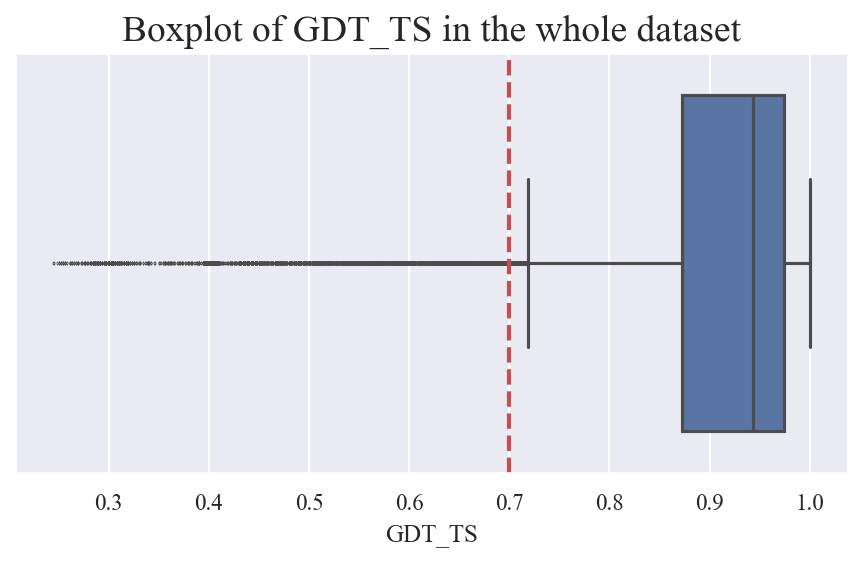

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='GDT_TS', fliersize=0.1)
plt.title('Boxplot of GDT_TS in the whole dataset', fontsize=18)
plt.axvline(x=0.7, color='r', linestyle='--', linewidth=2)
plt.tight_layout()

In [9]:
from sklearn.metrics import roc_curve, auc

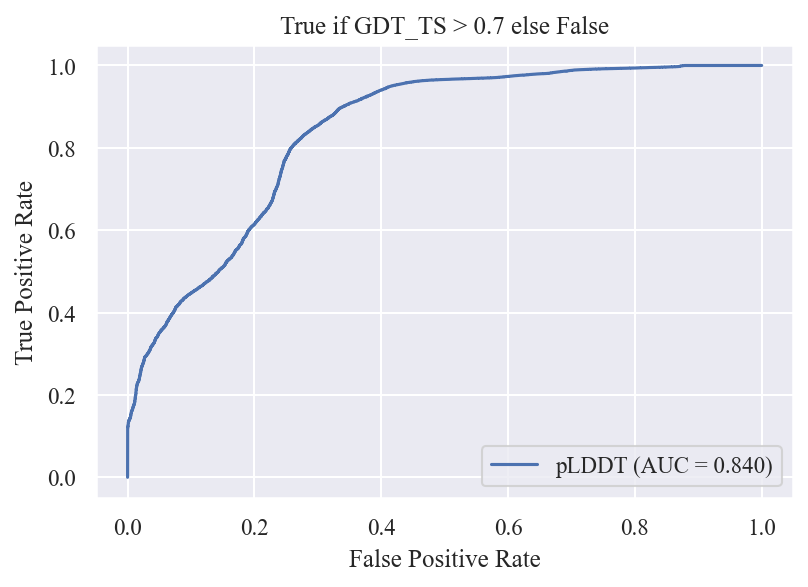

In [10]:
label = 'GDT_TS'
threshold = 0.7
l = f'{label}_{threshold}'
x = df[l]
score = 'pLDDT'
y = df[score]
fpr, tpr, thresholds = roc_curve(x, y)
a= auc(fpr, tpr)
plt.title(f'True if {label} > {threshold} else False')
plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107800 entries, 0 to 107799
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Model                                107800 non-null  object 
 1   TMscore                              107800 non-null  float64
 2   GDT_TS                               107800 non-null  float64
 3   GDT_HA                               107800 non-null  float64
 4   Global_LDDT                          98400 non-null   float64
 5   Mean_LDDT                            98400 non-null   float64
 6   pLDDT                                107800 non-null  float64
 7   pTMscore                             53900 non-null   float64
 8   Tolerance                            107800 non-null  float64
 9   ModelName                            107800 non-null  object 
 10  Seed                                 107800 non-null  int64  
 11  Recycle      

In [12]:
methods

['ProQ3D',
 'VoroCNN',
 'P3CMQA',
 'DeepAccNet',
 'DeepAccNet-Bert',
 'pLDDT',
 'pTMscore']

In [13]:
df['pTMscore'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
107795     True
107796     True
107797     True
107798     True
107799     True
Name: pTMscore, Length: 107800, dtype: bool

In [14]:
y.isna().any()

False

pTMscore


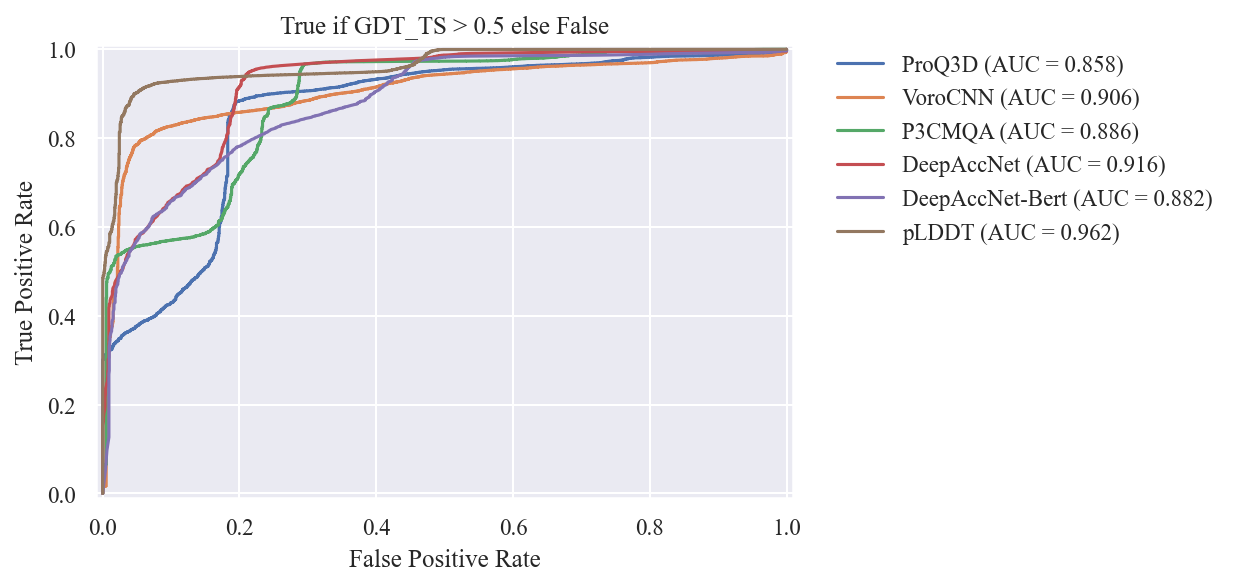

<Figure size 750x600 with 0 Axes>

pTMscore


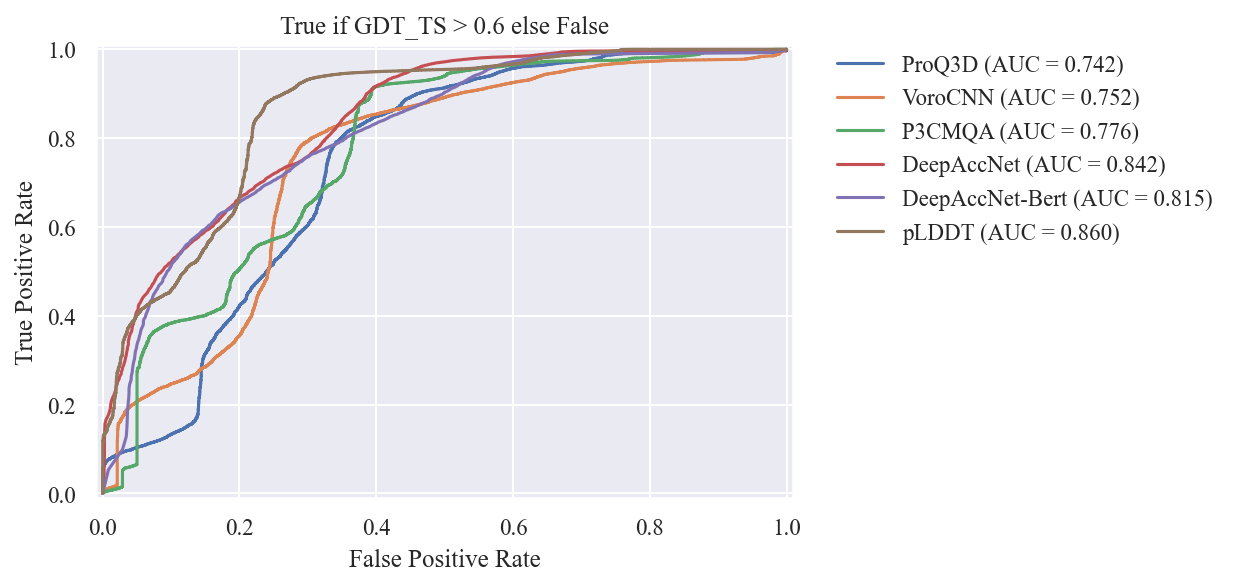

<Figure size 750x600 with 0 Axes>

pTMscore


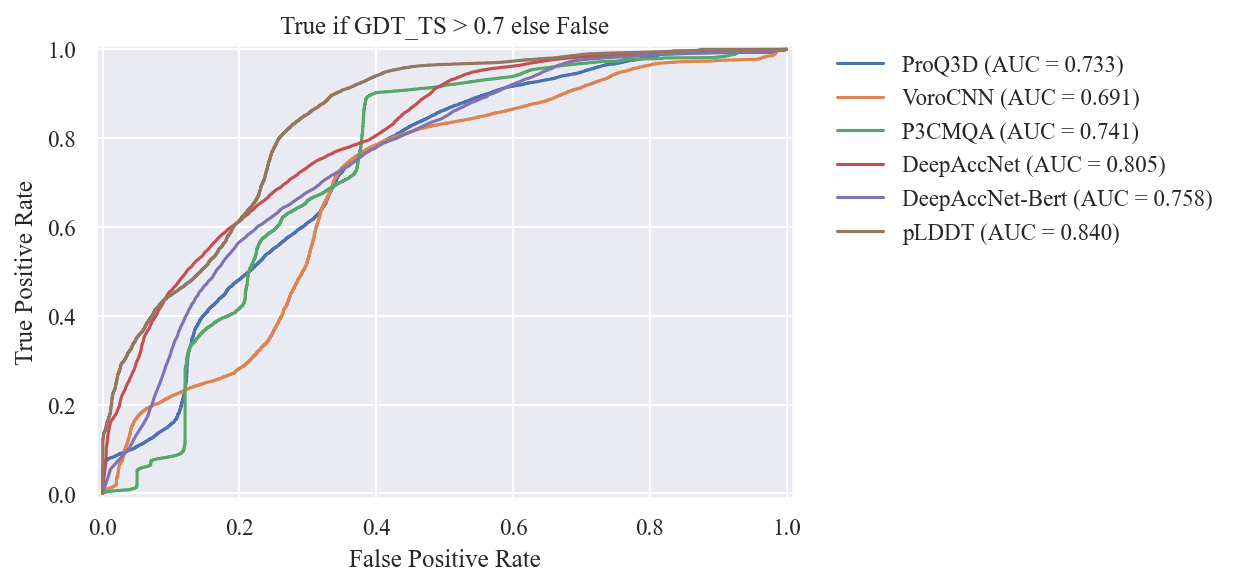

<Figure size 750x600 with 0 Axes>

pTMscore


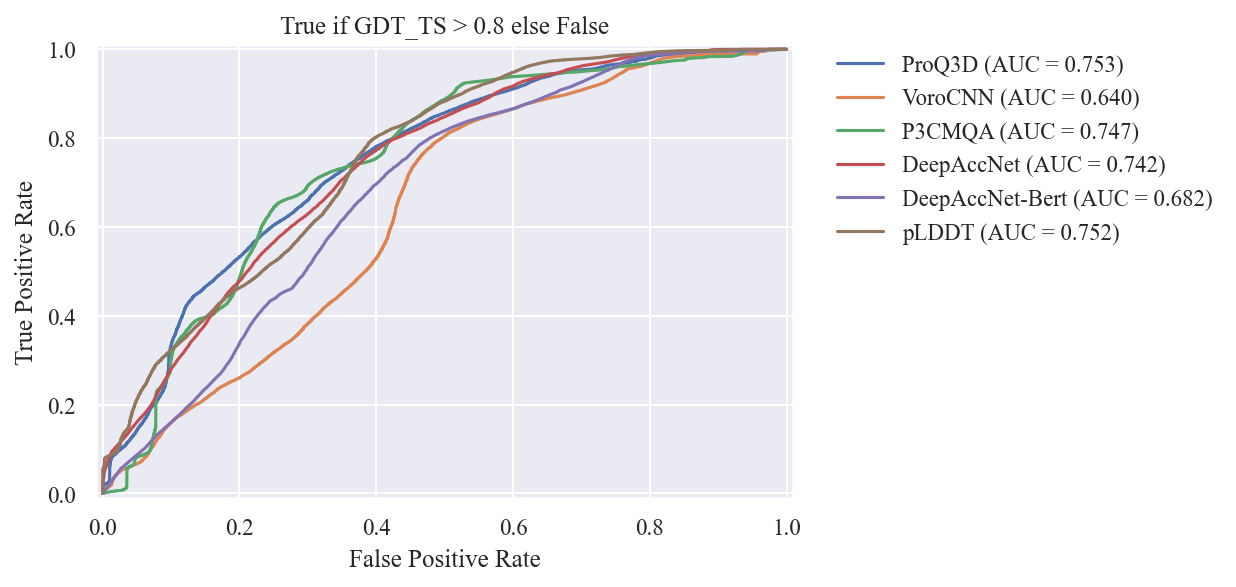

<Figure size 750x600 with 0 Axes>

pTMscore


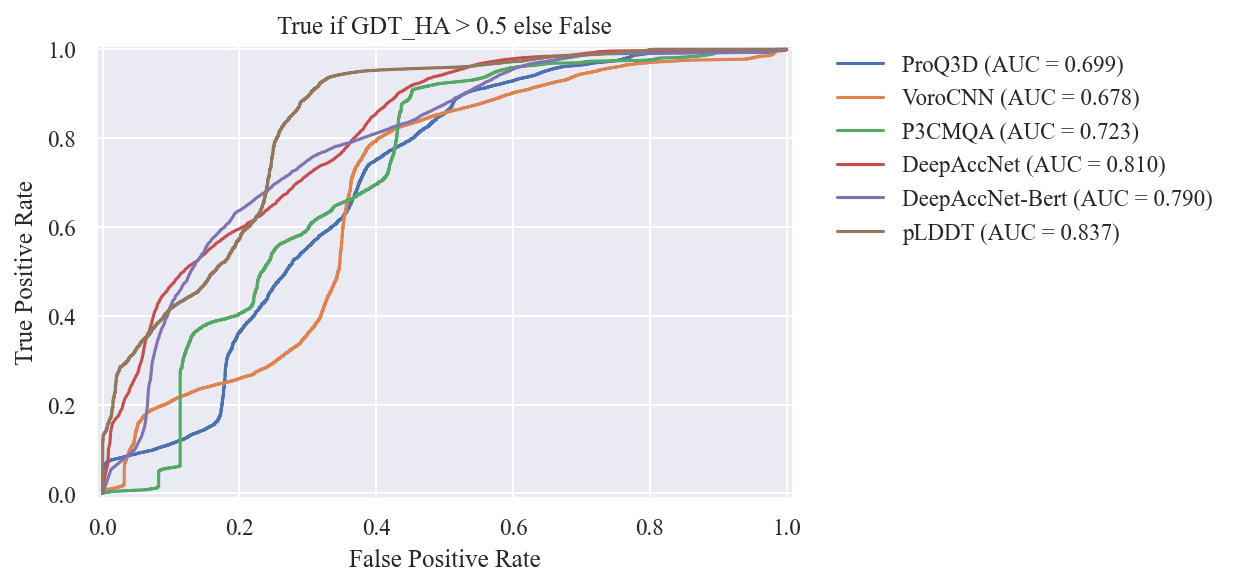

<Figure size 750x600 with 0 Axes>

pTMscore


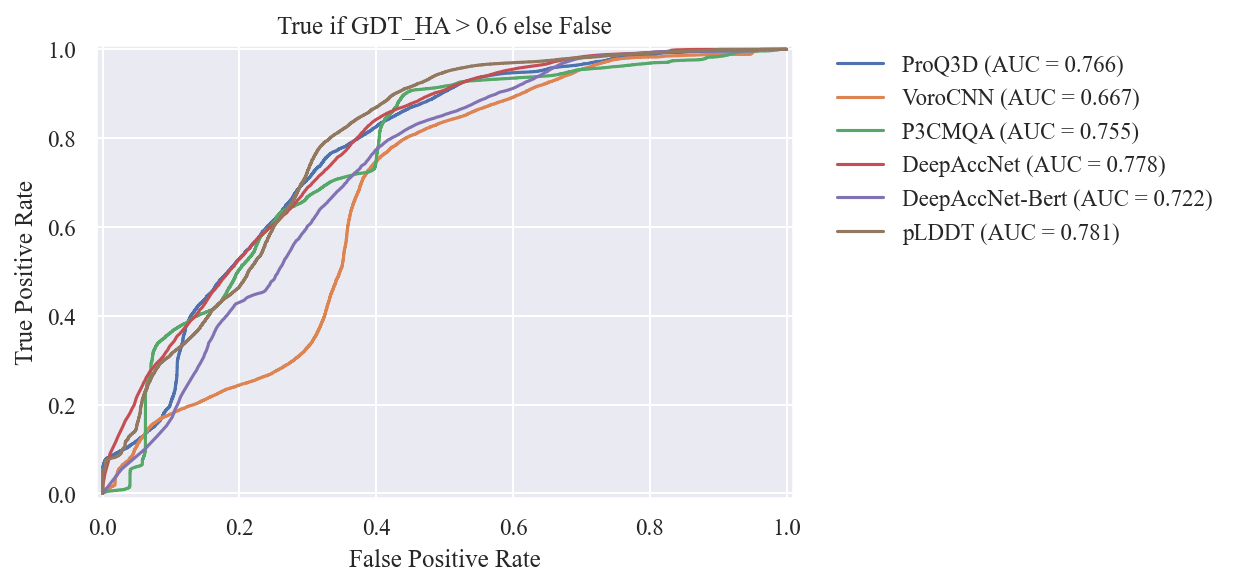

<Figure size 750x600 with 0 Axes>

pTMscore


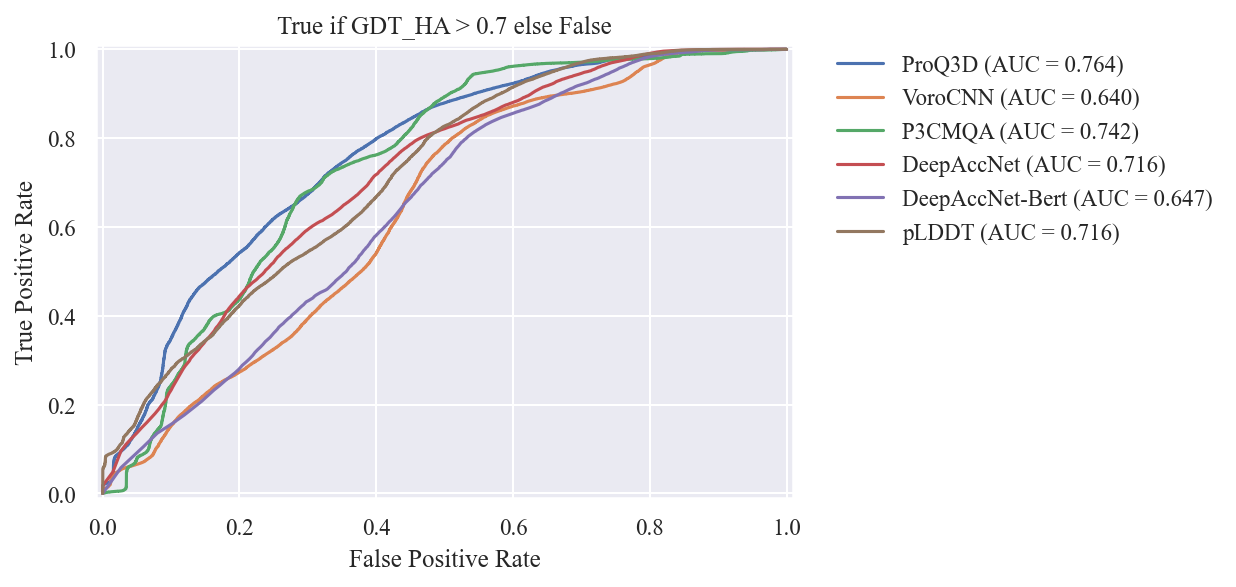

<Figure size 750x600 with 0 Axes>

pTMscore


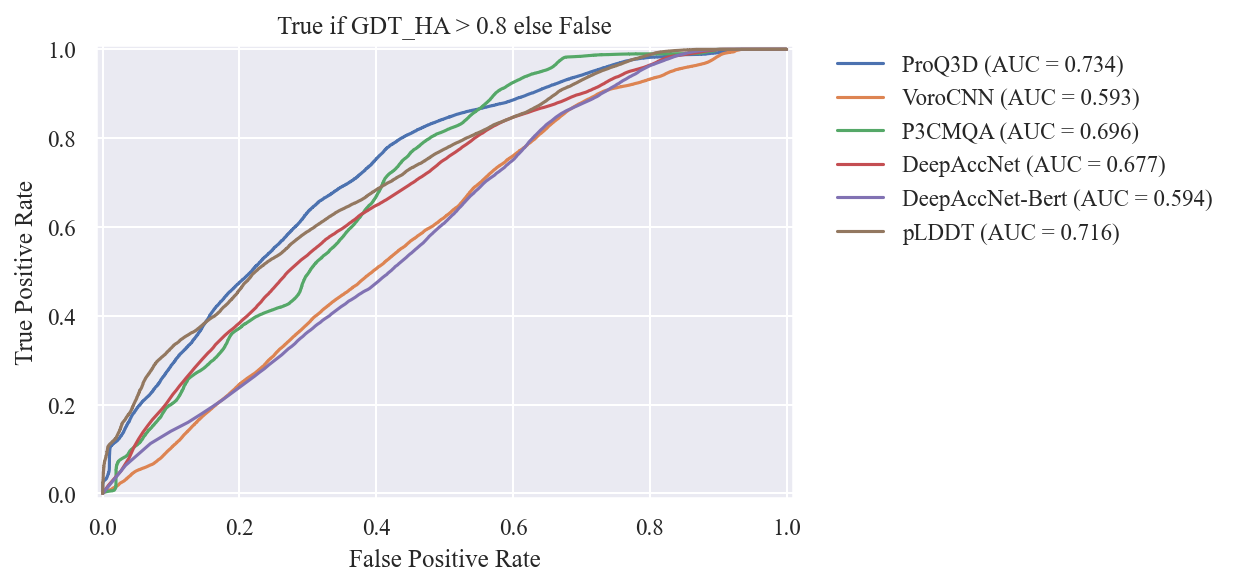

<Figure size 750x600 with 0 Axes>

pTMscore


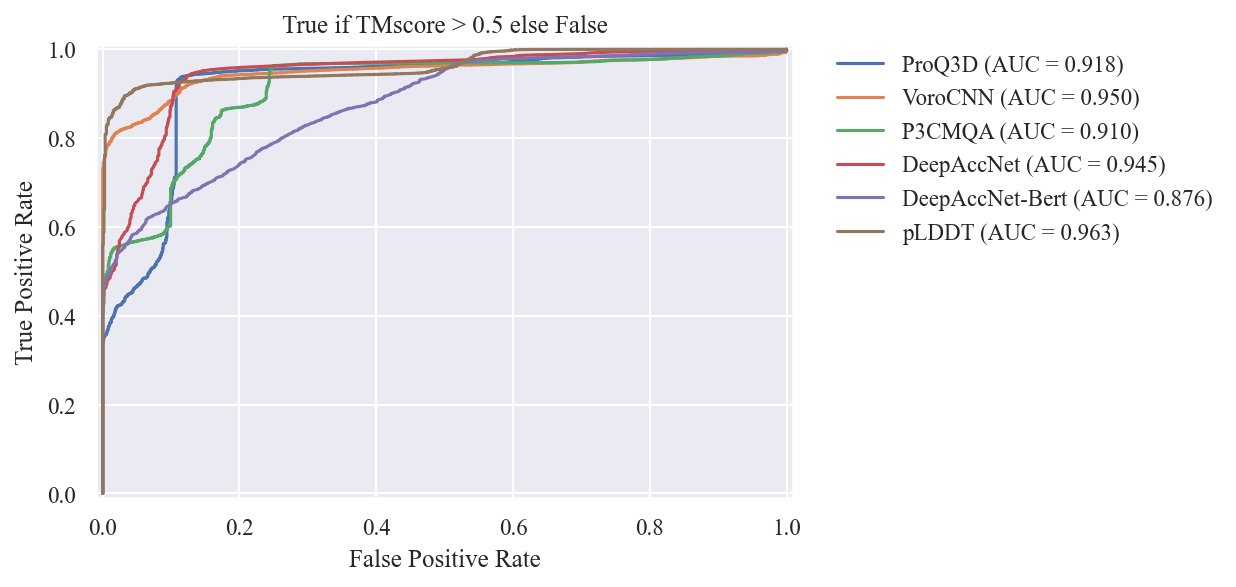

<Figure size 750x600 with 0 Axes>

pTMscore


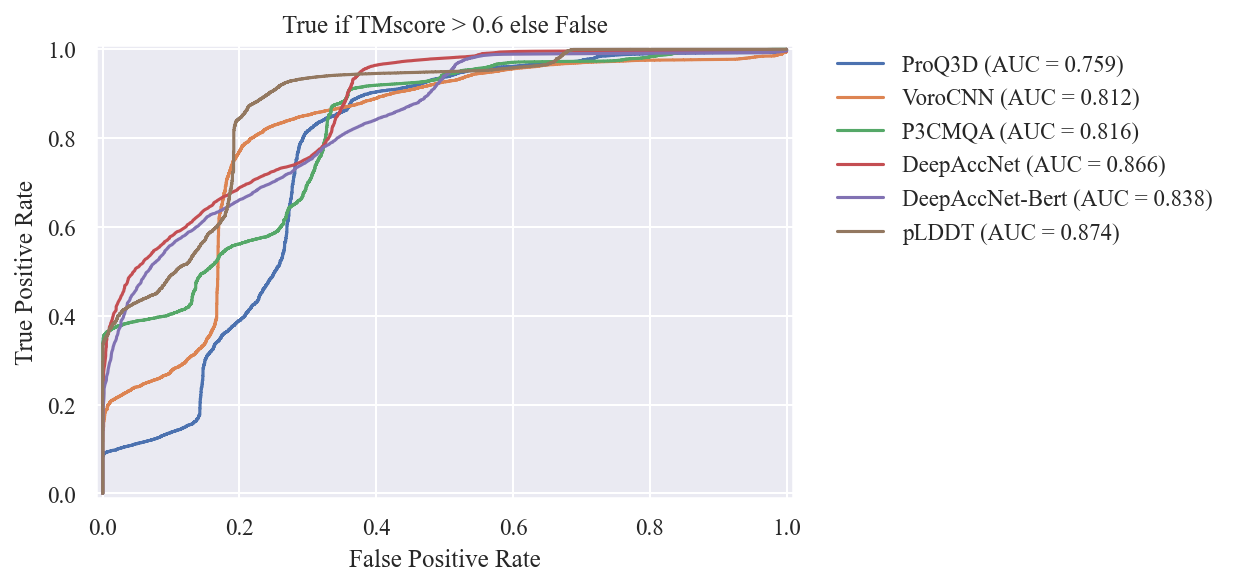

<Figure size 750x600 with 0 Axes>

pTMscore


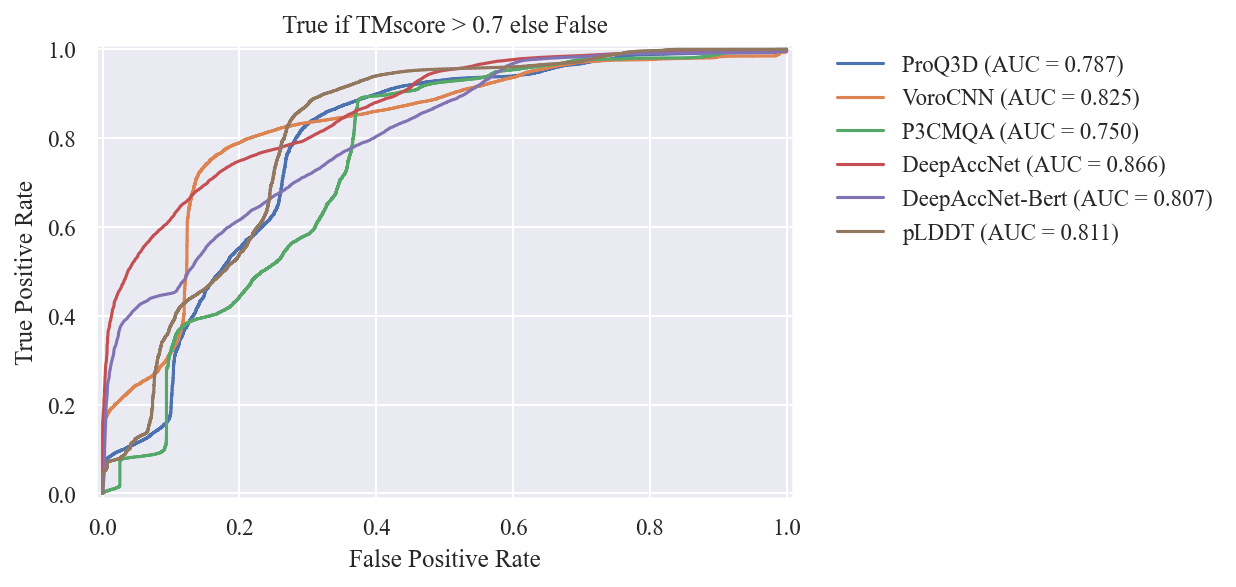

<Figure size 750x600 with 0 Axes>

pTMscore


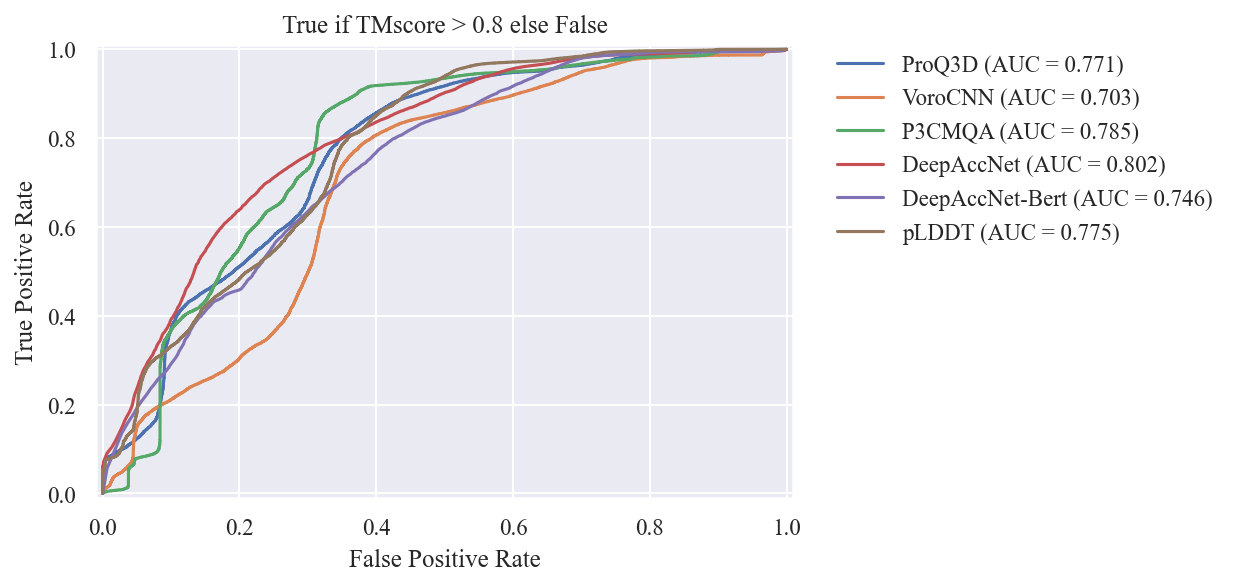

<Figure size 750x600 with 0 Axes>

pTMscore


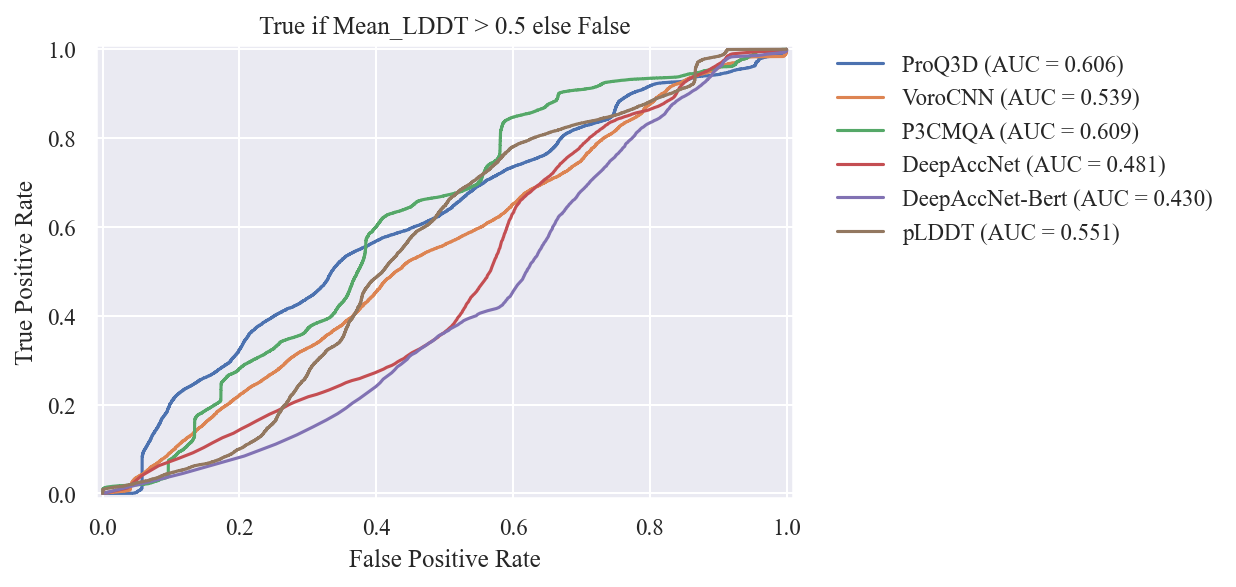

<Figure size 750x600 with 0 Axes>

pTMscore


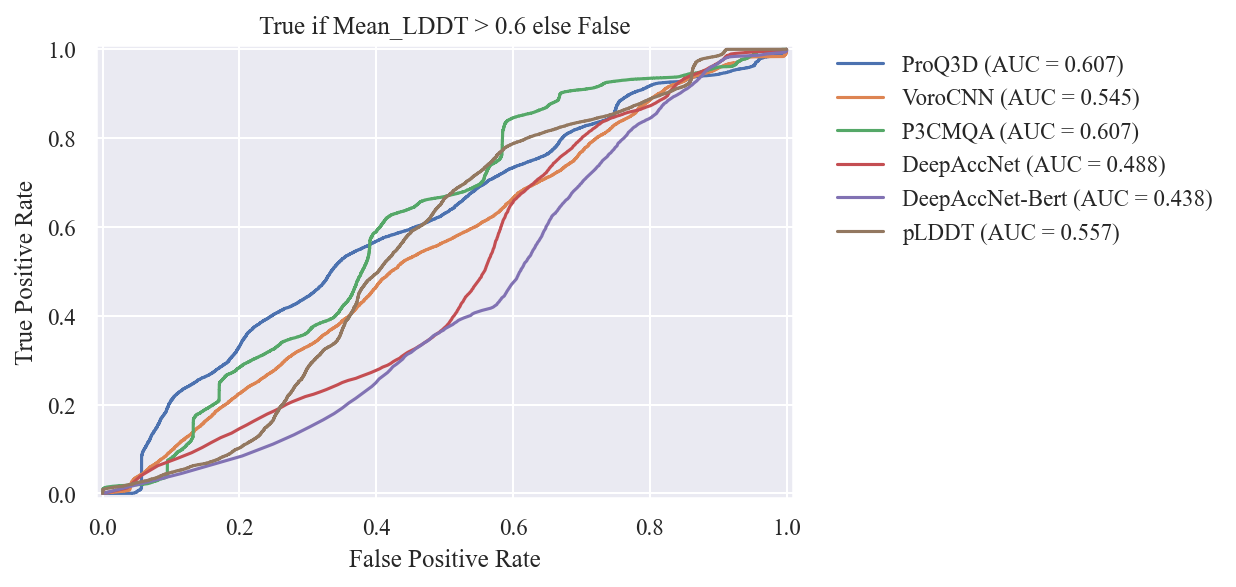

<Figure size 750x600 with 0 Axes>

pTMscore


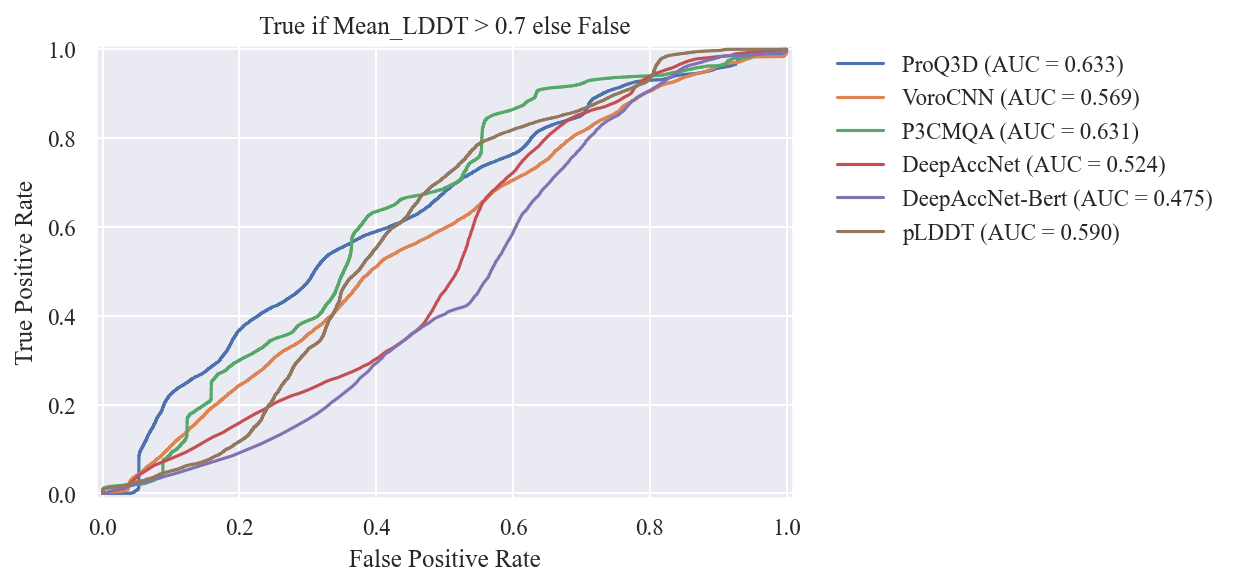

<Figure size 750x600 with 0 Axes>

pTMscore


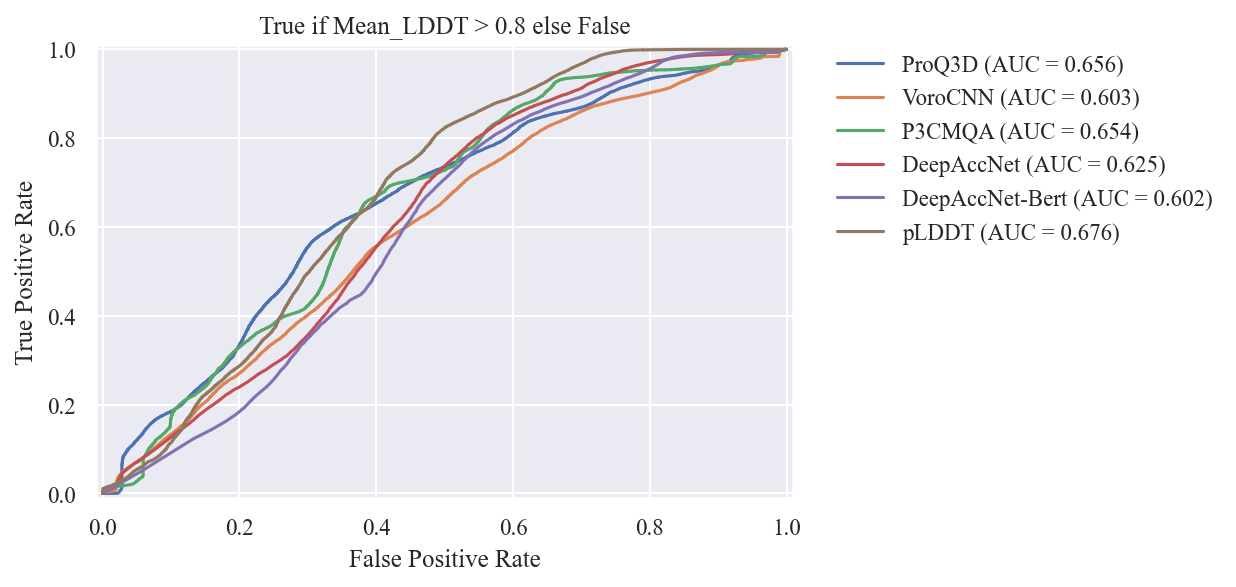

<Figure size 750x600 with 0 Axes>

In [15]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        x = df[l]
        for score in methods:
            y = df[score]
            if y.isna().any():
                print(score)
                continue
            fpr, tpr, thres = roc_curve(x, y)
            a= auc(fpr, tpr)
            plt.title(f'True if {label} > {threshold} else False')
            plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
            plt.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, facecolor='white', edgecolor='white')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.figure(figsize=(5, 4))
        plt.tight_layout()
        plt.show()

pTMscore


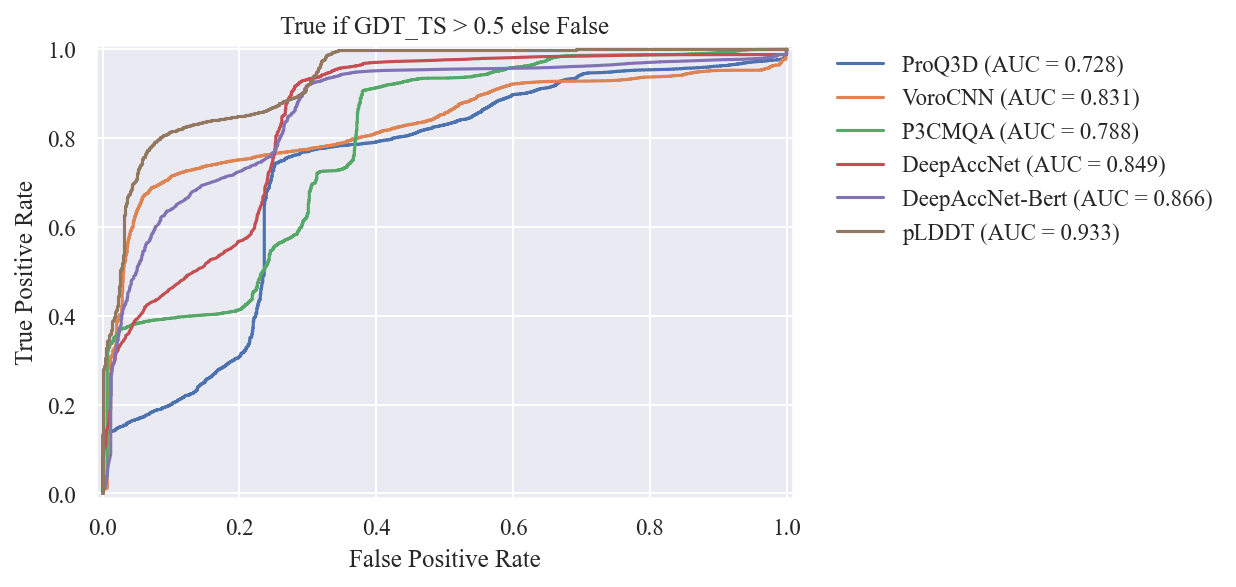

<Figure size 750x600 with 0 Axes>

pTMscore


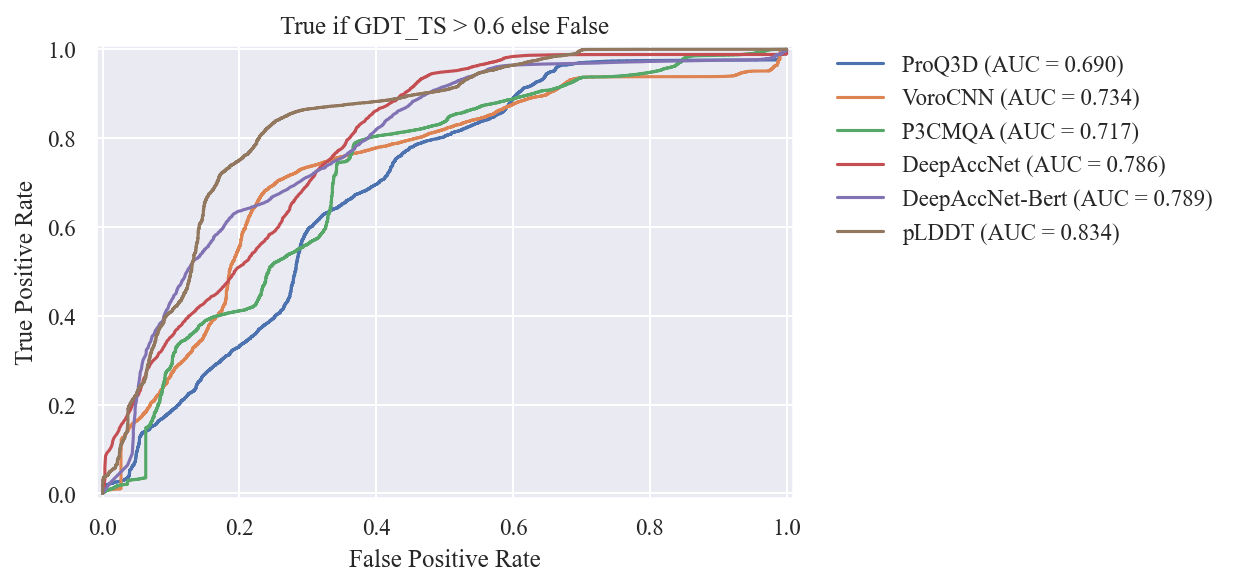

<Figure size 750x600 with 0 Axes>

pTMscore


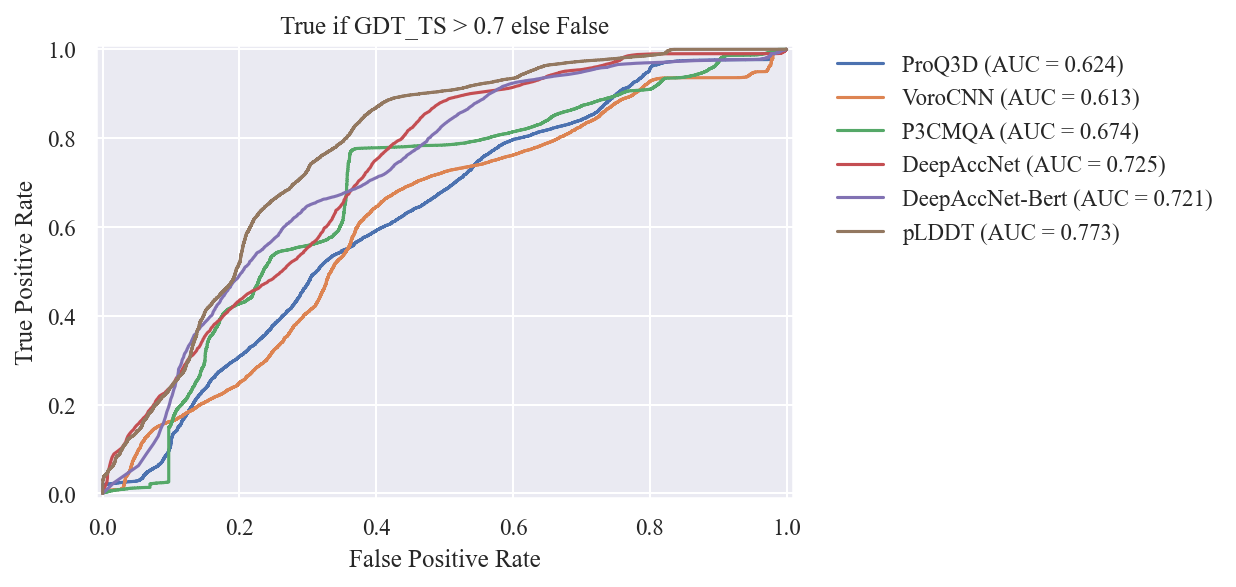

<Figure size 750x600 with 0 Axes>

pTMscore


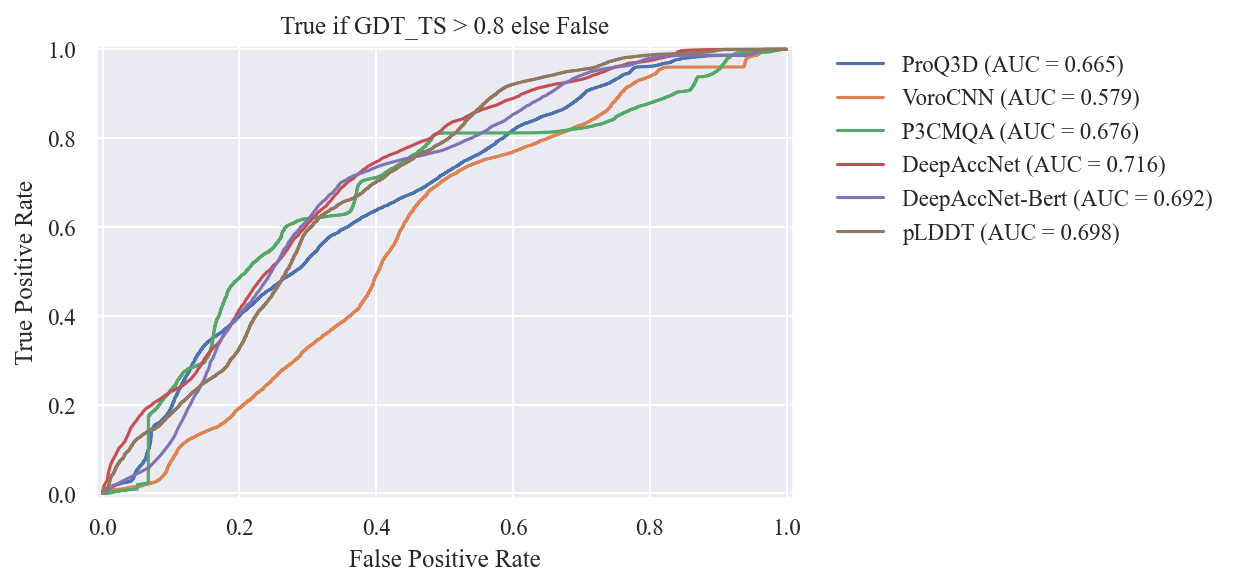

<Figure size 750x600 with 0 Axes>

pTMscore


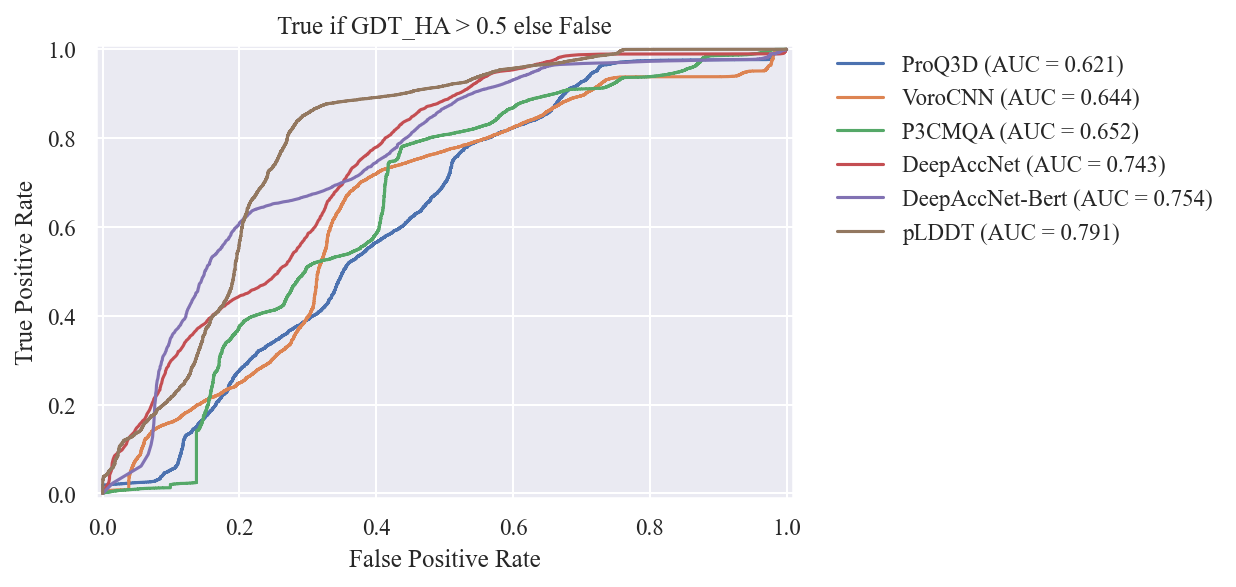

<Figure size 750x600 with 0 Axes>

pTMscore


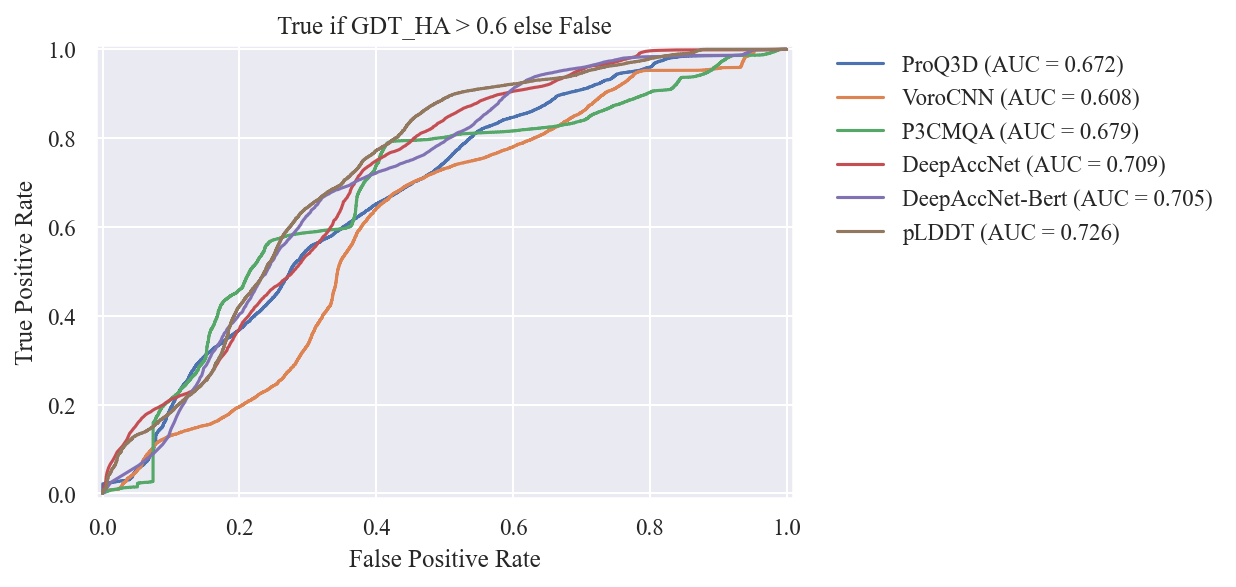

<Figure size 750x600 with 0 Axes>

pTMscore


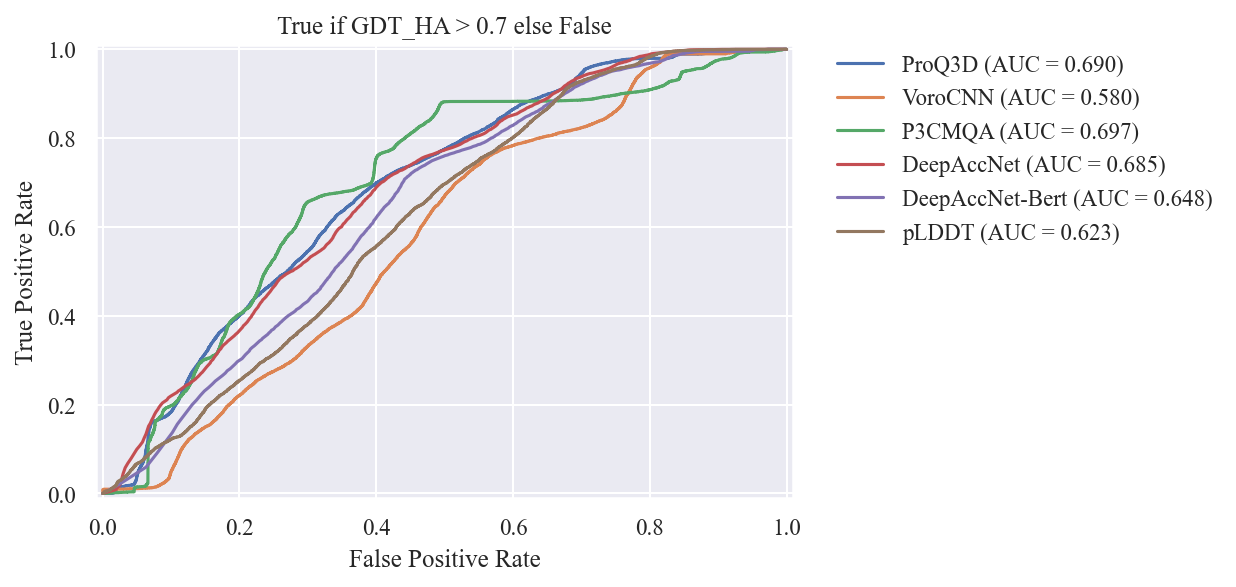

<Figure size 750x600 with 0 Axes>

pTMscore


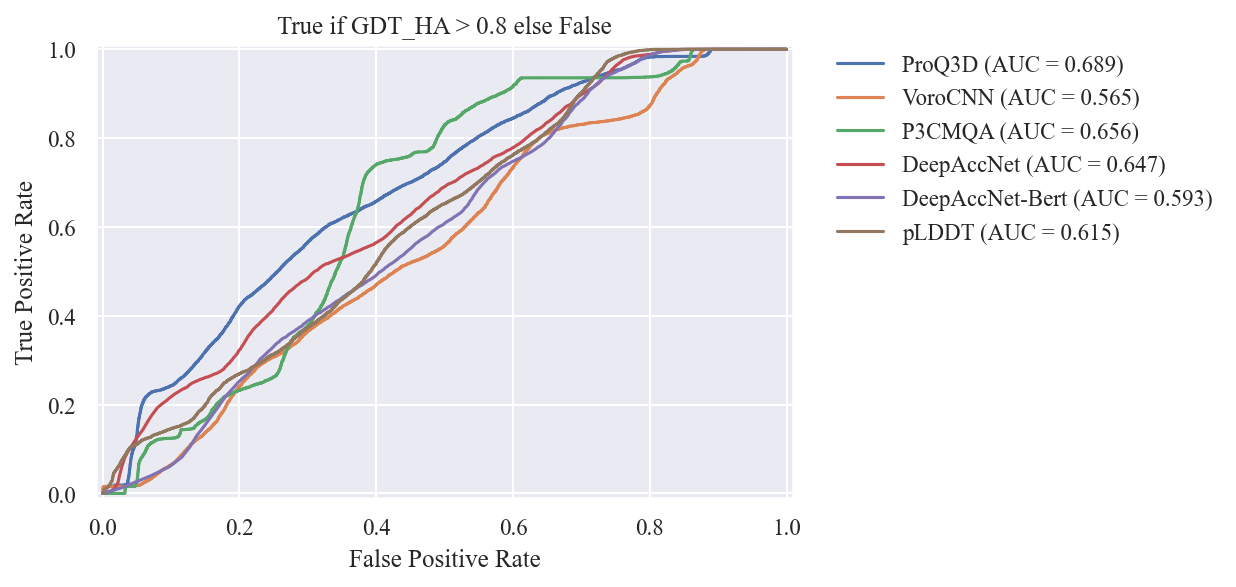

<Figure size 750x600 with 0 Axes>

pTMscore


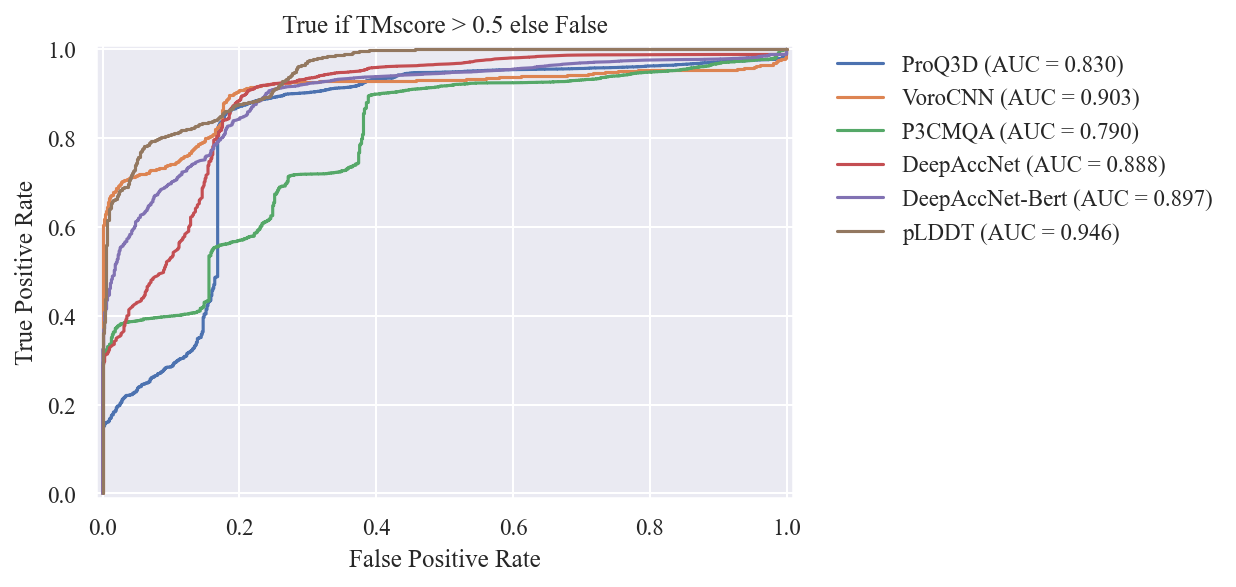

<Figure size 750x600 with 0 Axes>

pTMscore


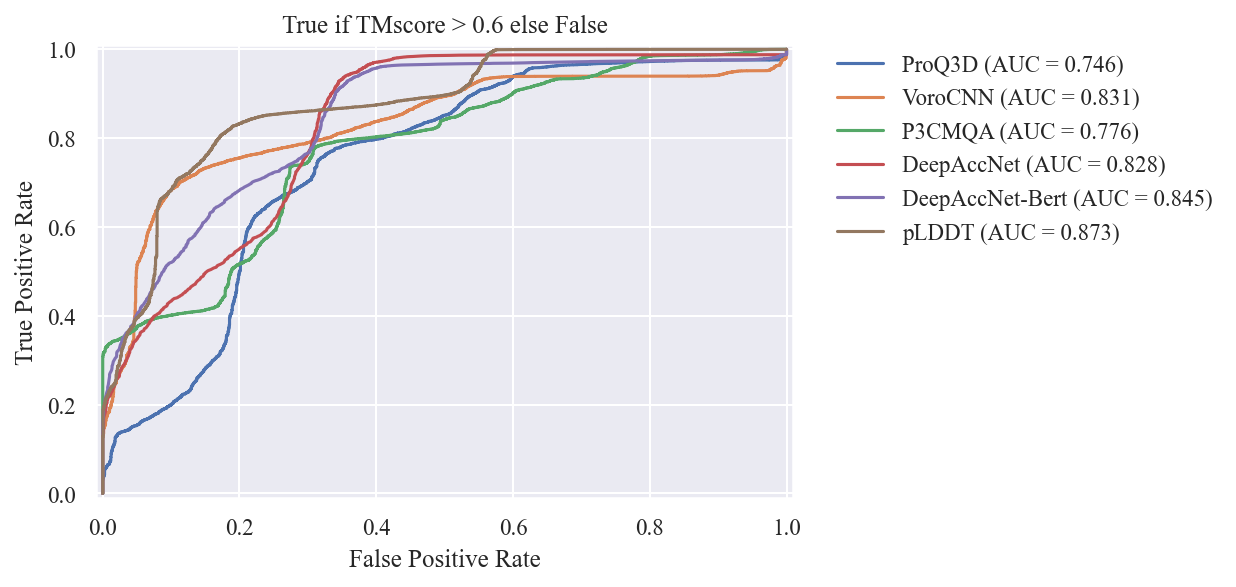

<Figure size 750x600 with 0 Axes>

pTMscore


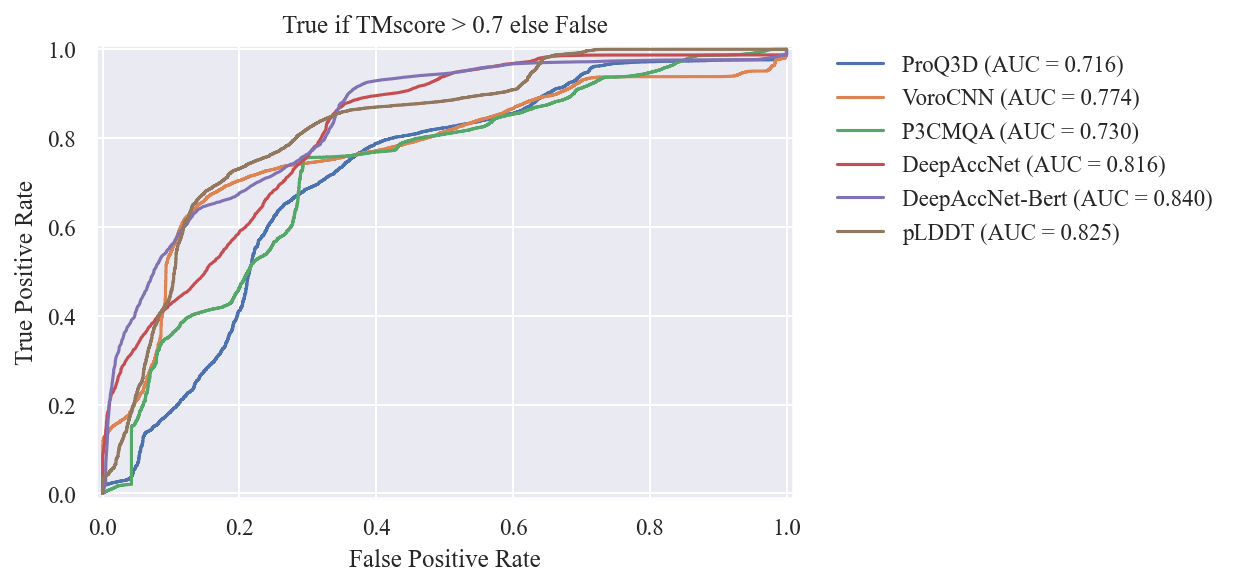

<Figure size 750x600 with 0 Axes>

pTMscore


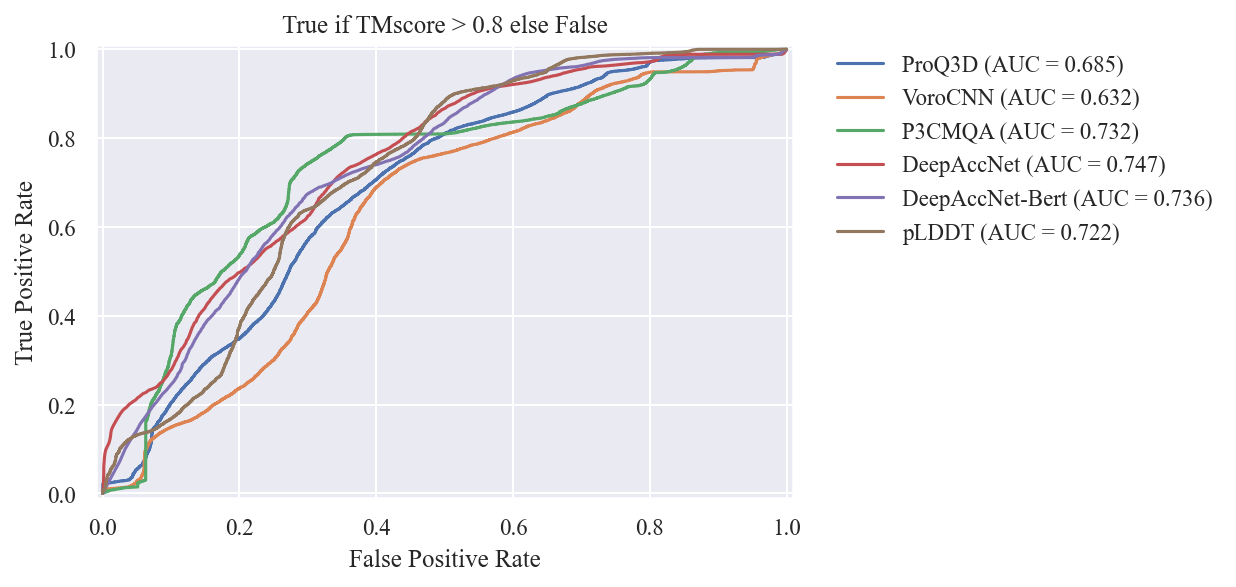

<Figure size 750x600 with 0 Axes>

pTMscore


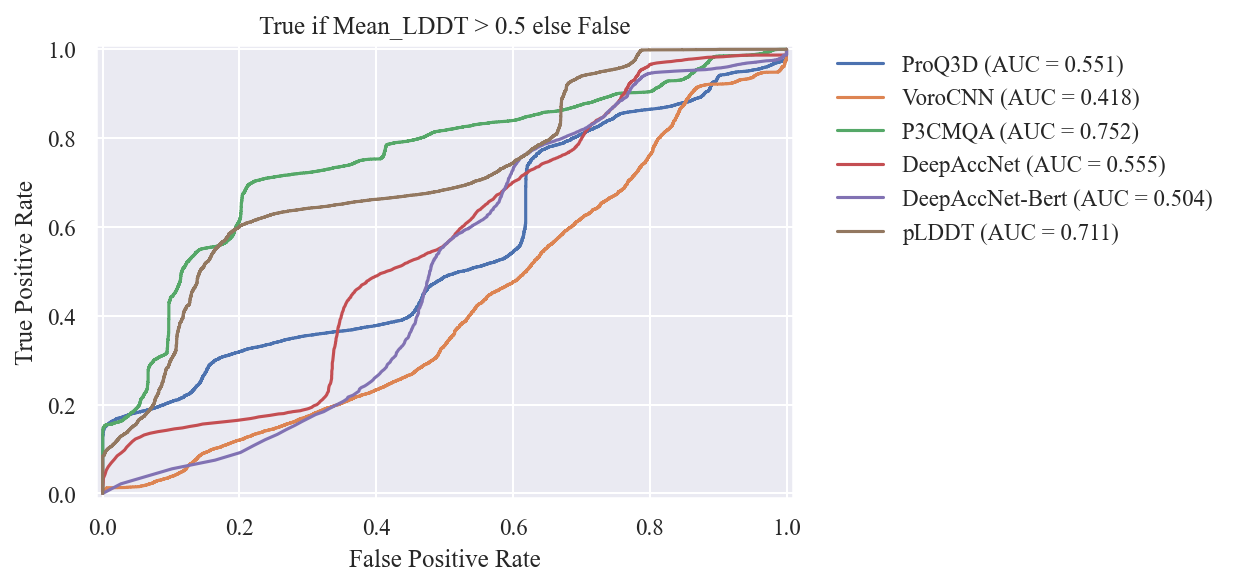

<Figure size 750x600 with 0 Axes>

pTMscore


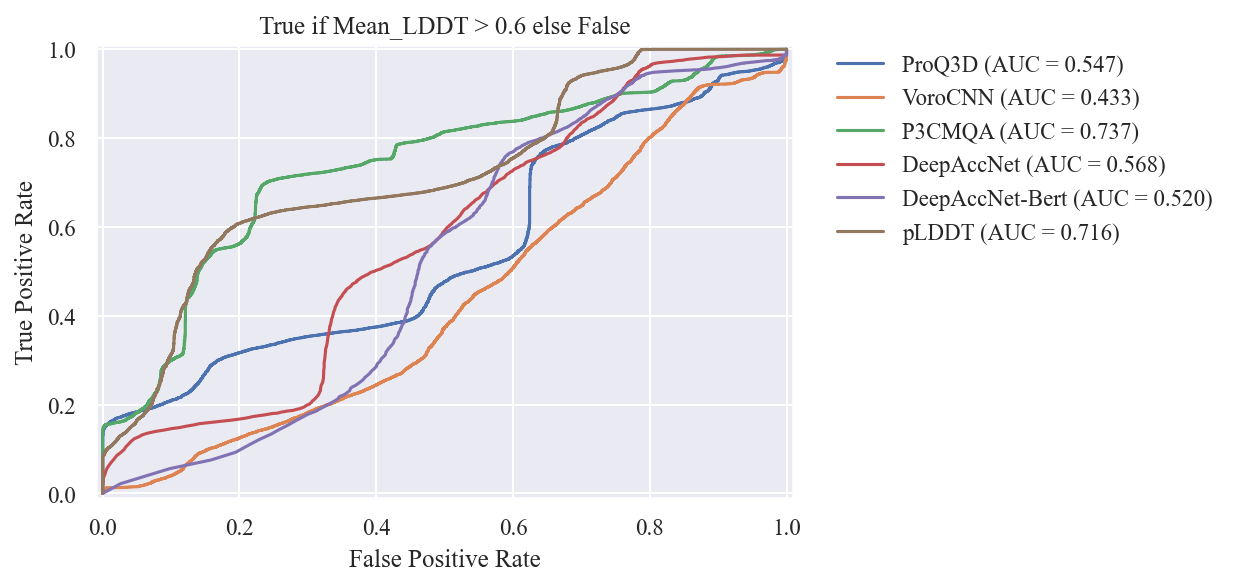

<Figure size 750x600 with 0 Axes>

pTMscore


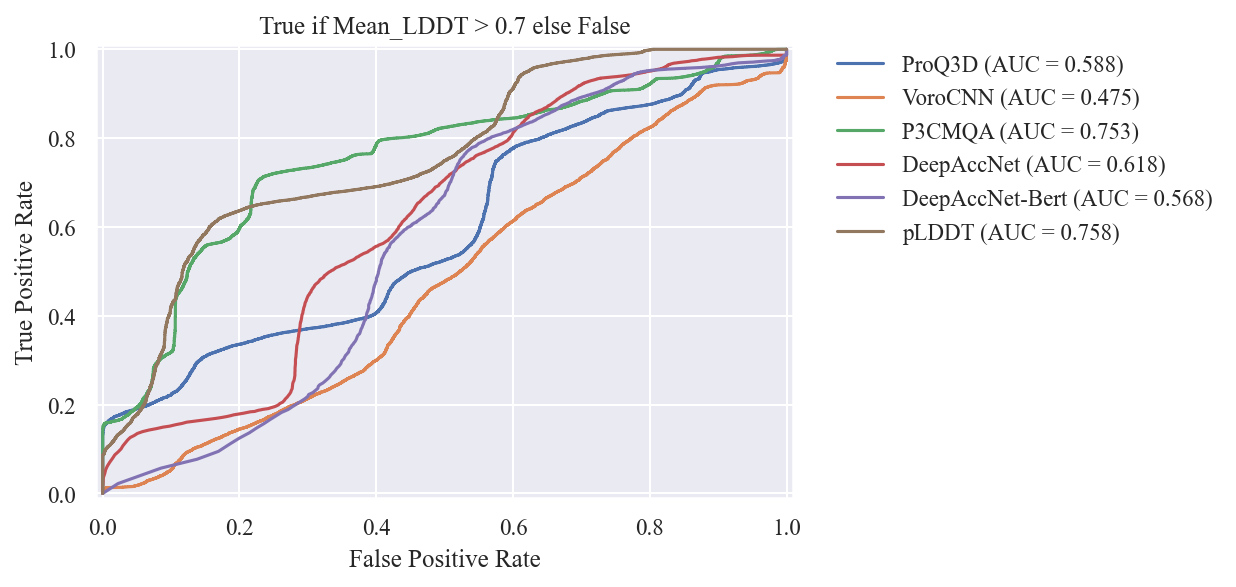

<Figure size 750x600 with 0 Axes>

pTMscore


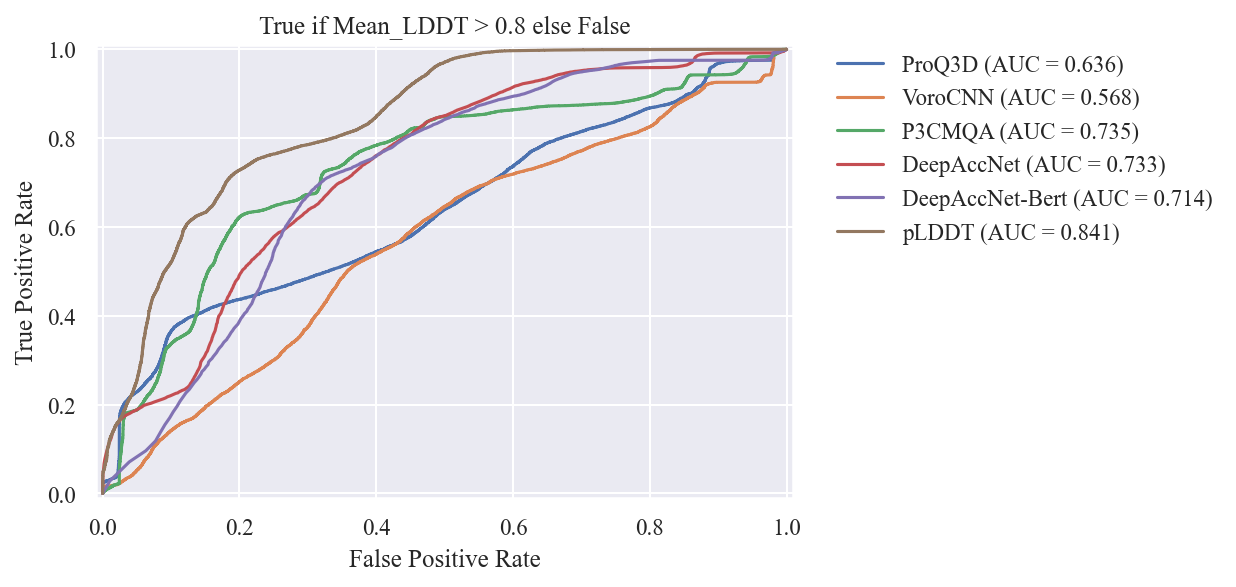

<Figure size 750x600 with 0 Axes>

In [16]:
# For targets with difference between max gdtts and min gdtts over threshold
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        x = fil_df[l]
        for score in methods:
            y = fil_df[score]
            if y.isna().any():
                print(score)
                continue
            fpr, tpr, thres = roc_curve(x, y)
            a= auc(fpr, tpr)
            plt.title(f'True if {label} > {threshold} else False')
            plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
            plt.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, facecolor='white', edgecolor='white')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.figure(figsize=(5, 4))
        plt.tight_layout()
        plt.show()

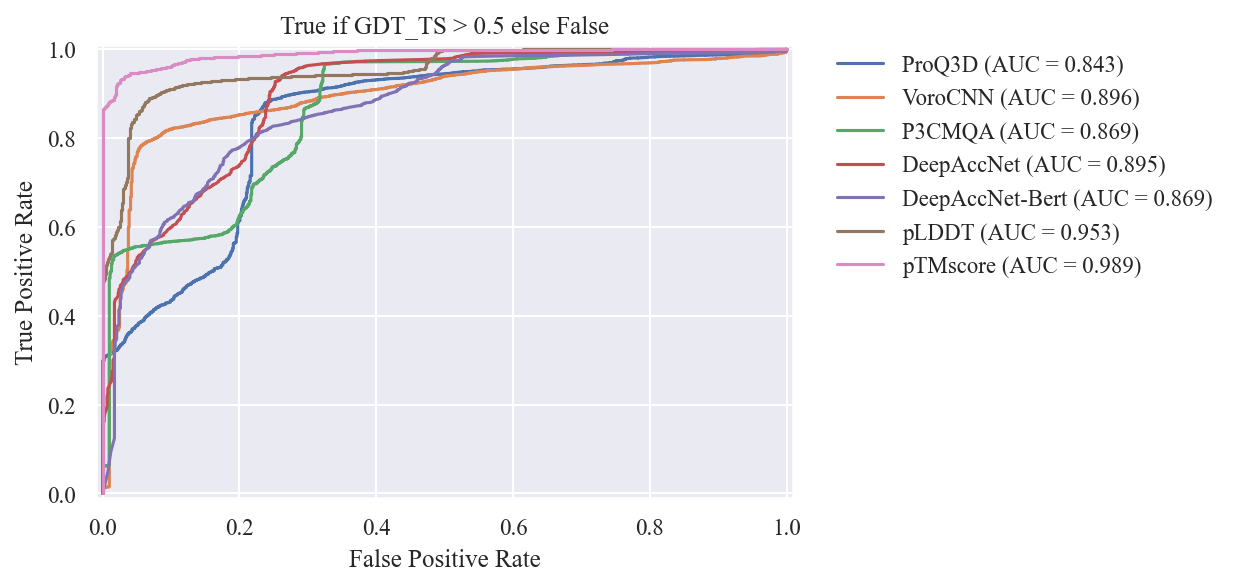

<Figure size 750x600 with 0 Axes>

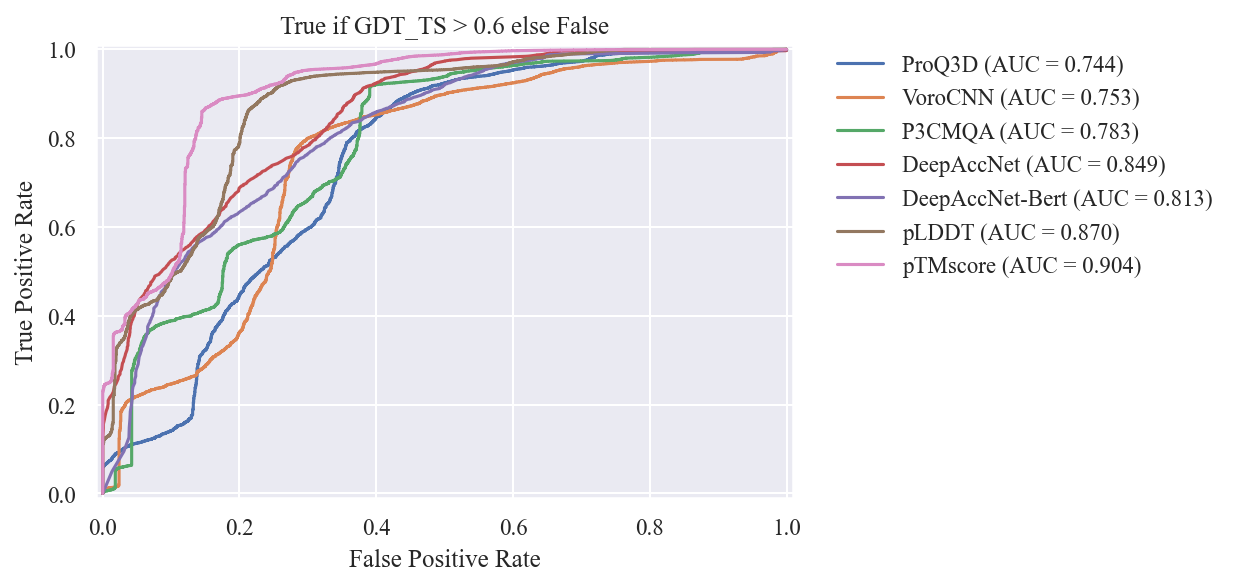

<Figure size 750x600 with 0 Axes>

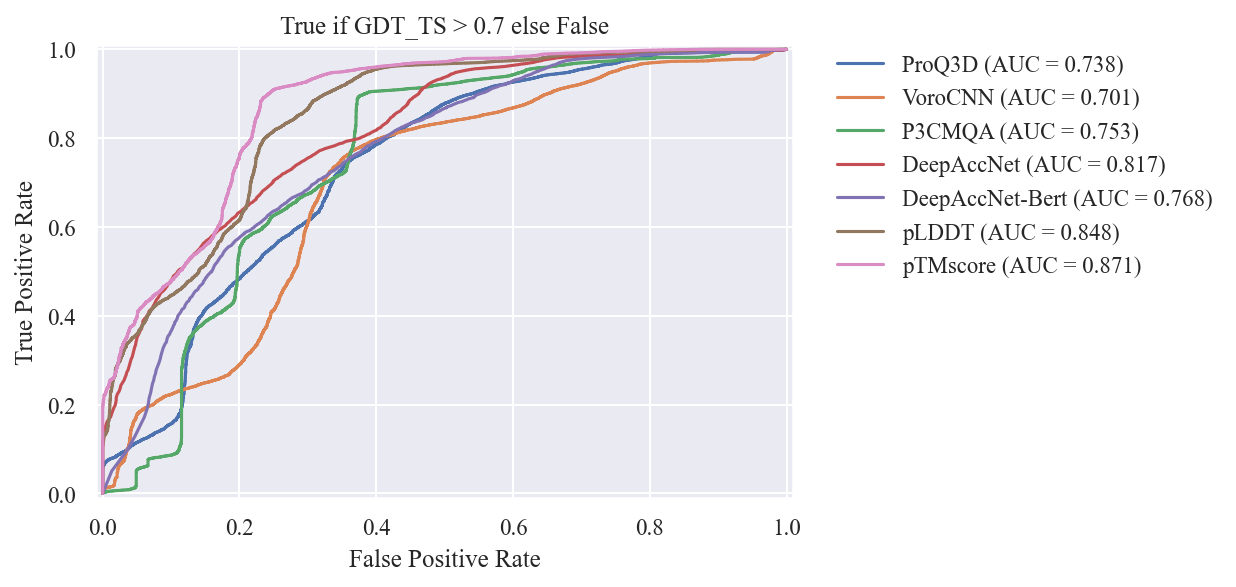

<Figure size 750x600 with 0 Axes>

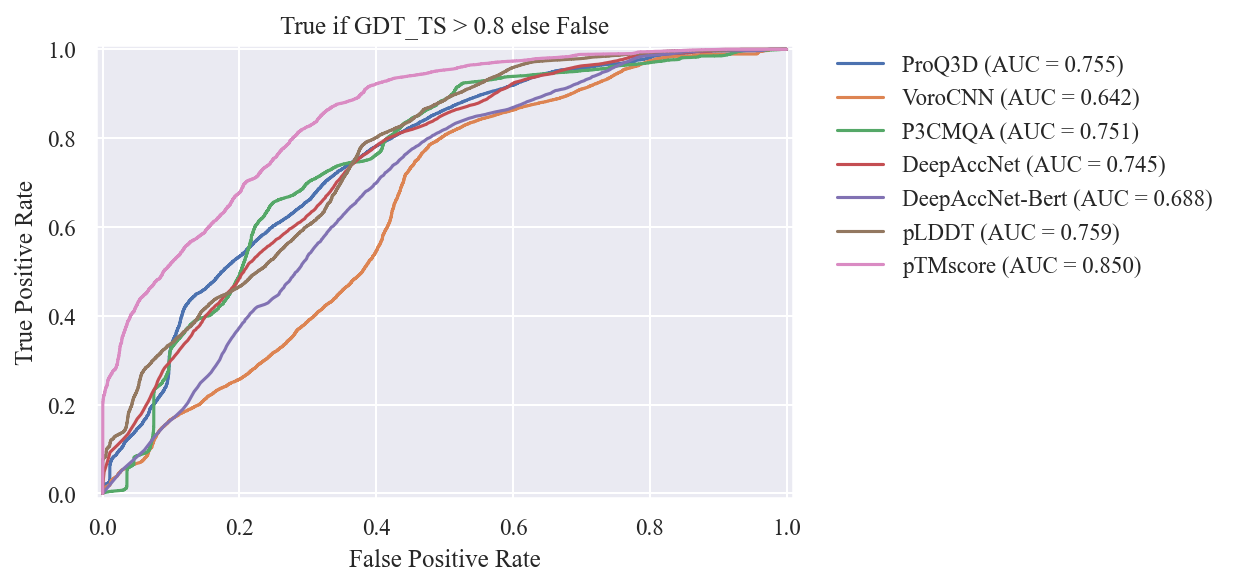

<Figure size 750x600 with 0 Axes>

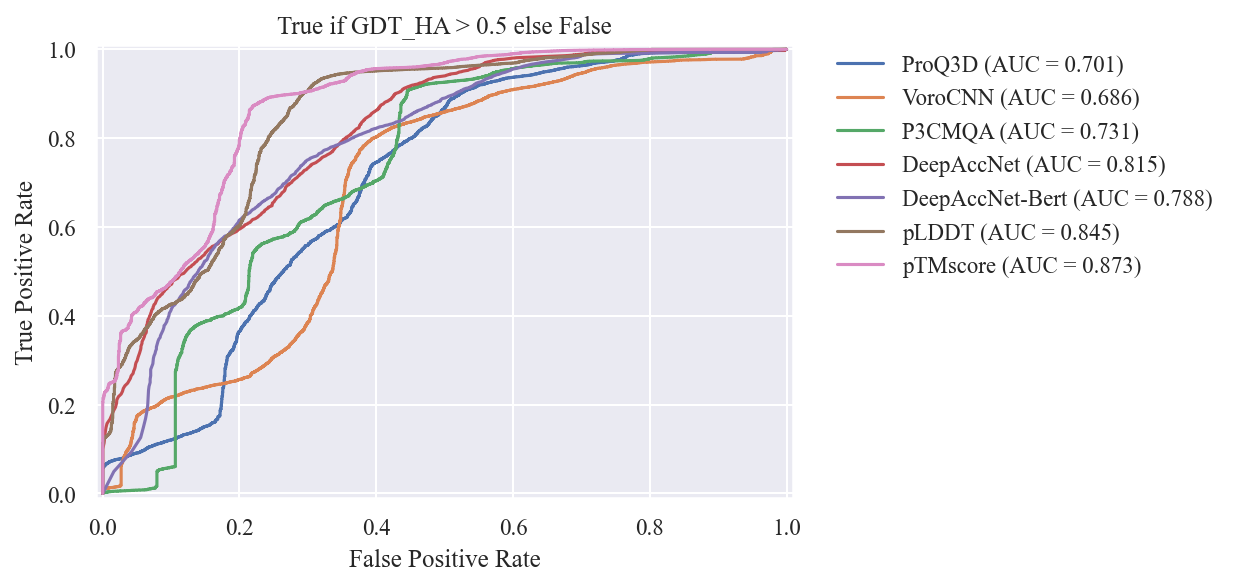

<Figure size 750x600 with 0 Axes>

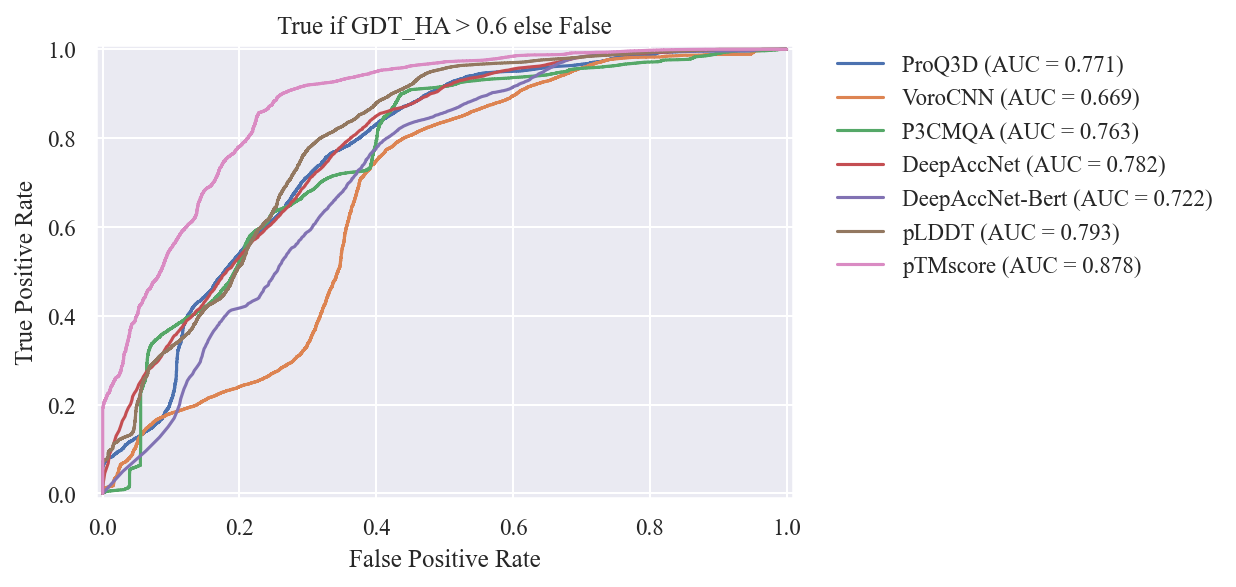

<Figure size 750x600 with 0 Axes>

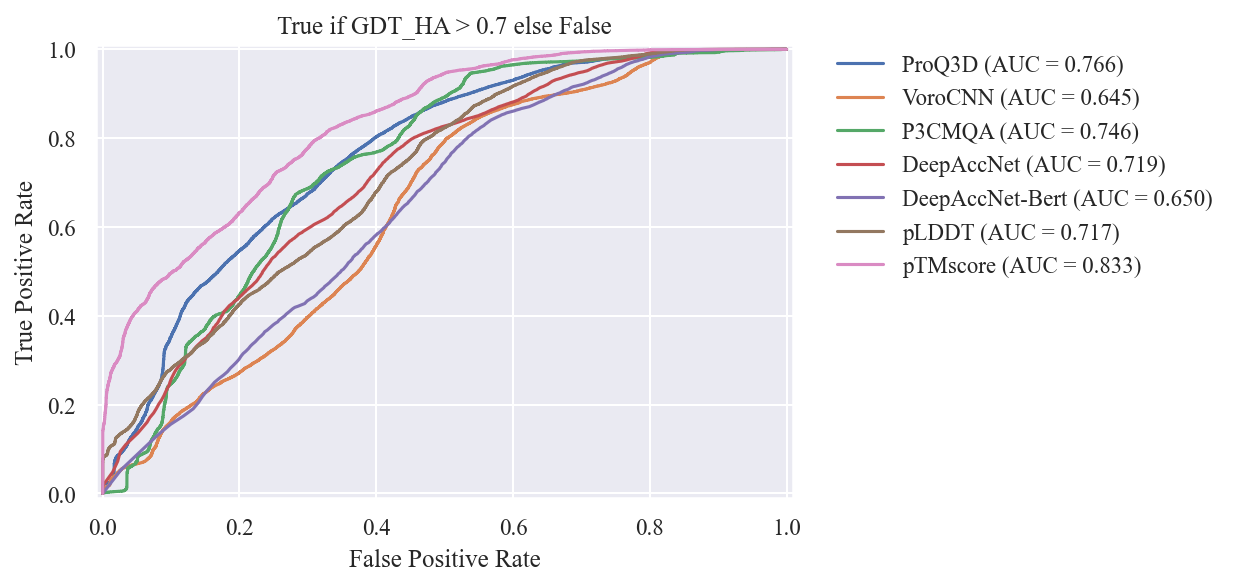

<Figure size 750x600 with 0 Axes>

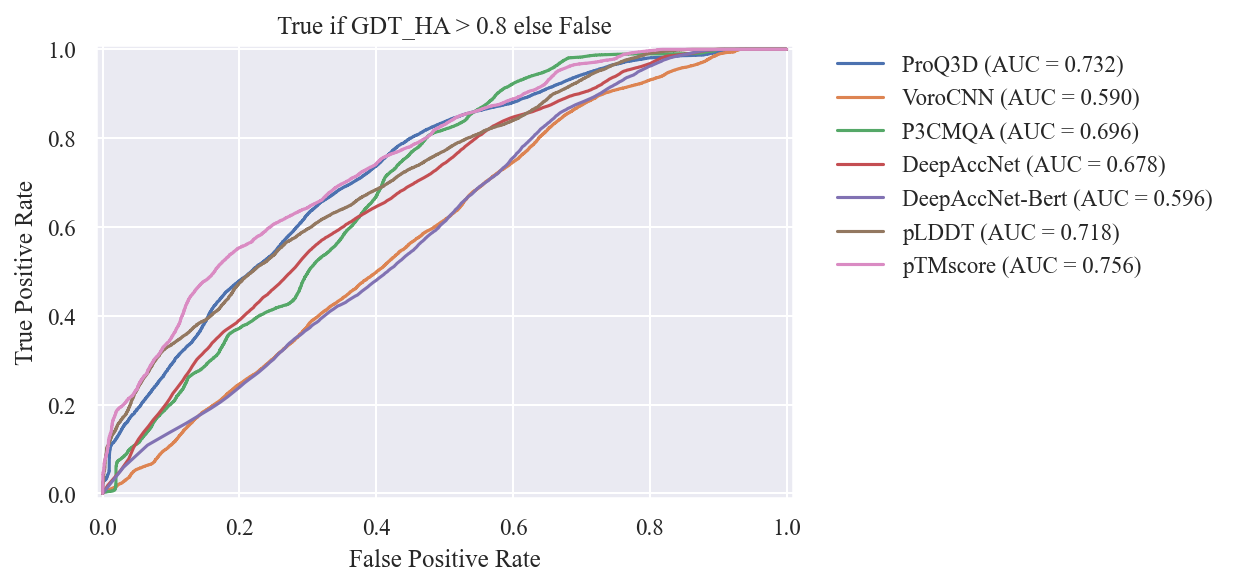

<Figure size 750x600 with 0 Axes>

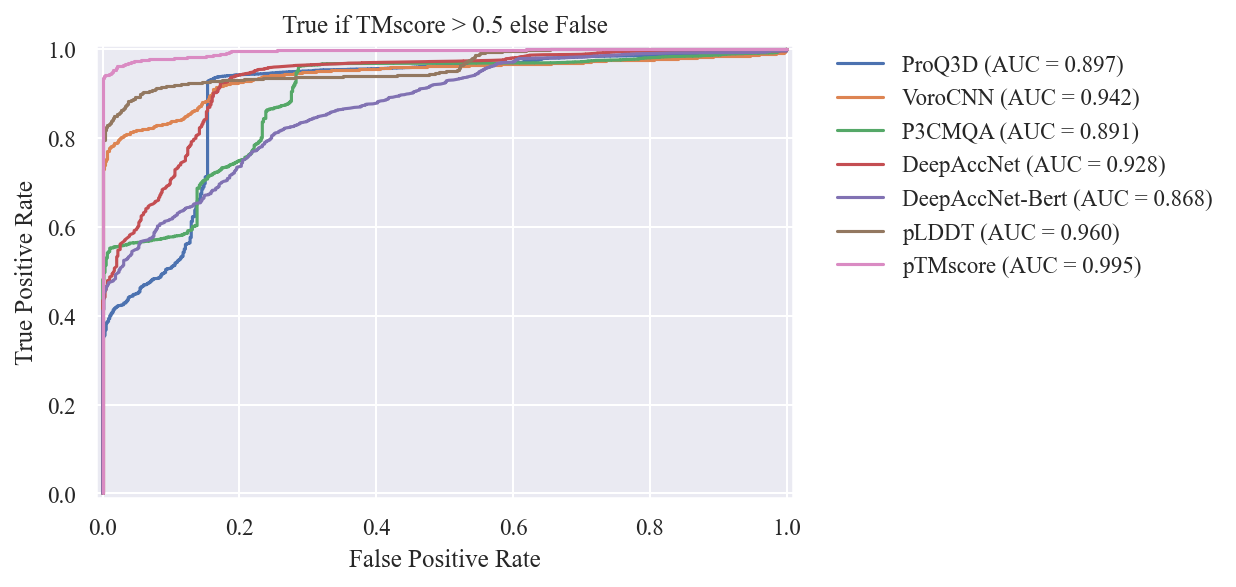

<Figure size 750x600 with 0 Axes>

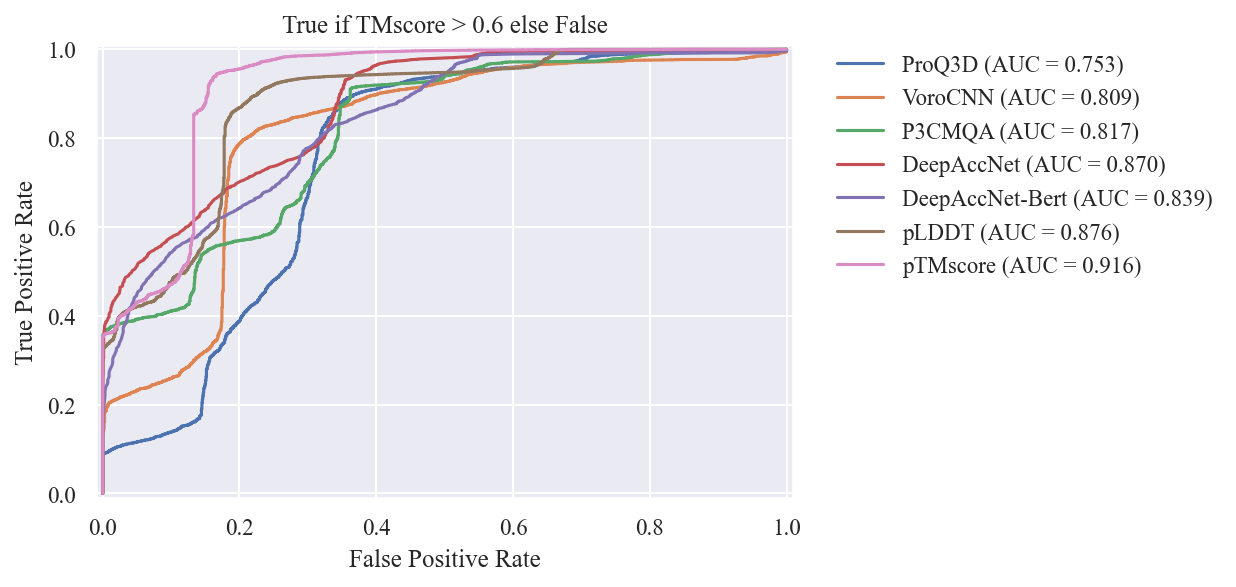

<Figure size 750x600 with 0 Axes>

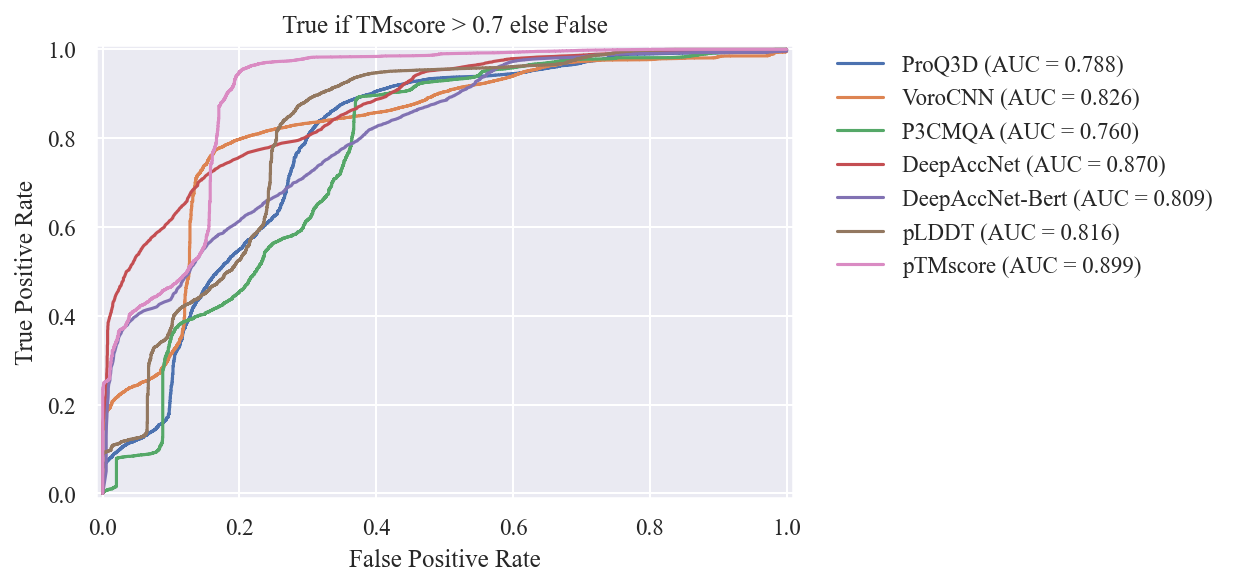

<Figure size 750x600 with 0 Axes>

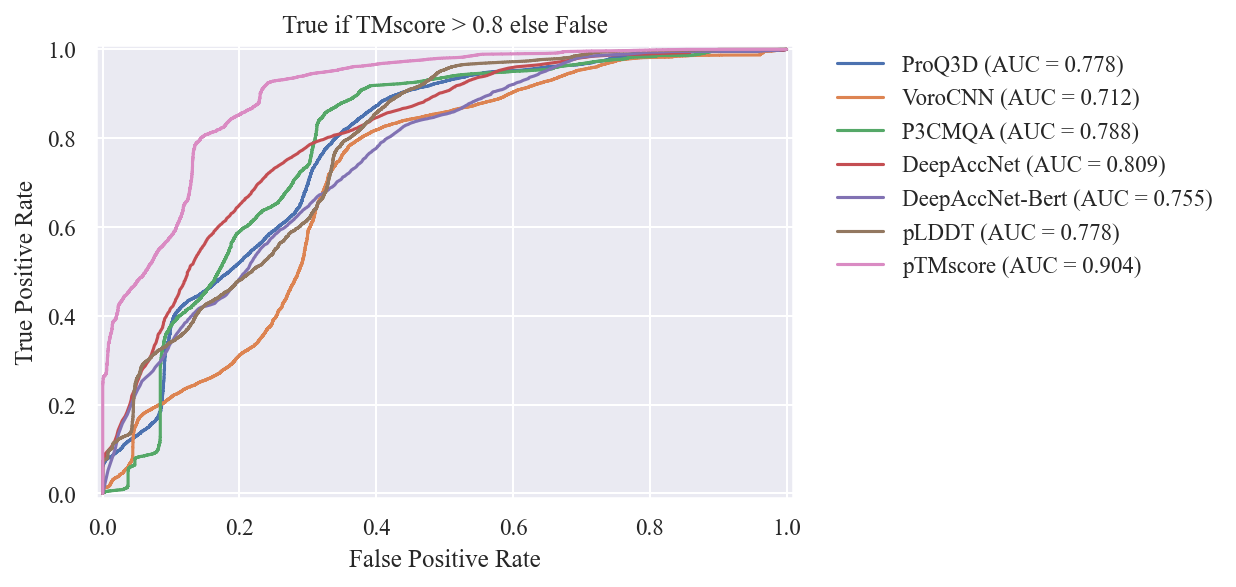

<Figure size 750x600 with 0 Axes>

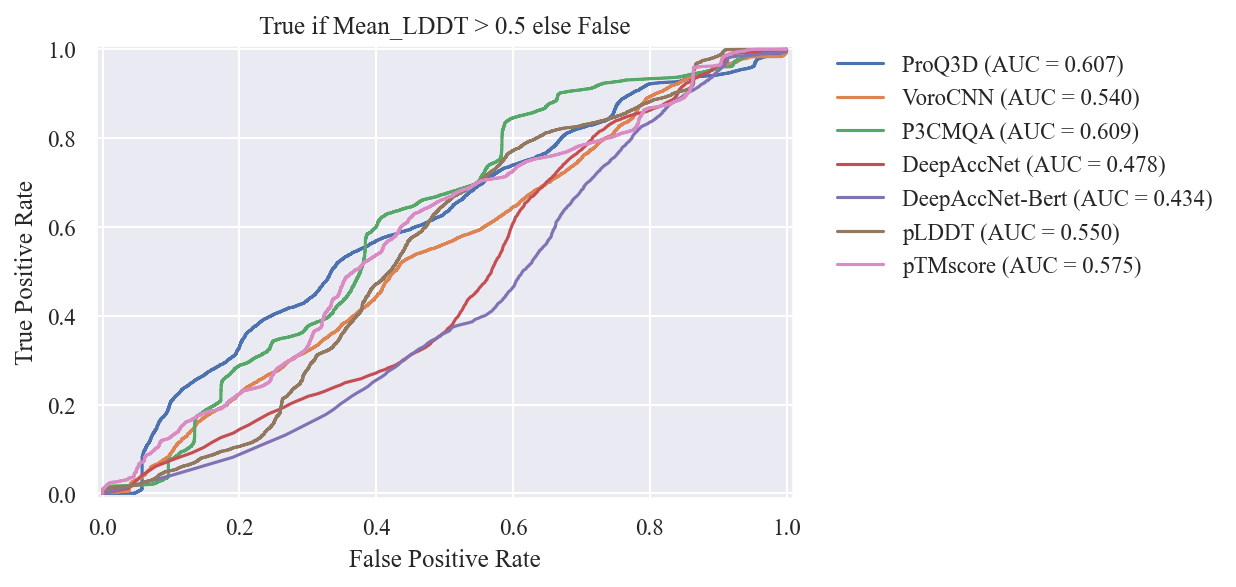

<Figure size 750x600 with 0 Axes>

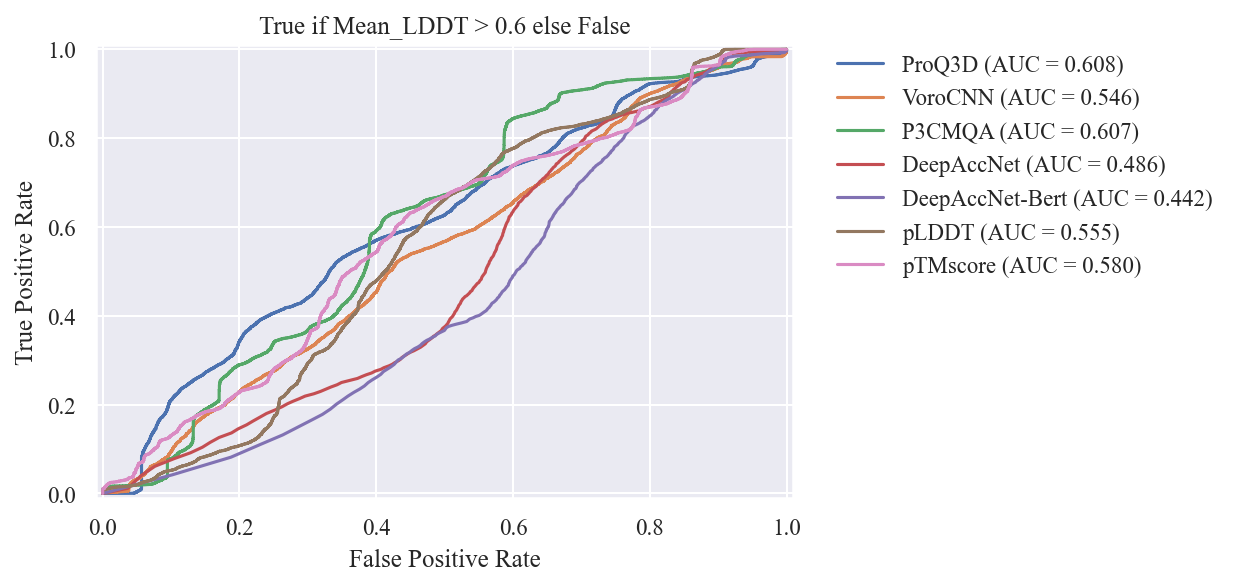

<Figure size 750x600 with 0 Axes>

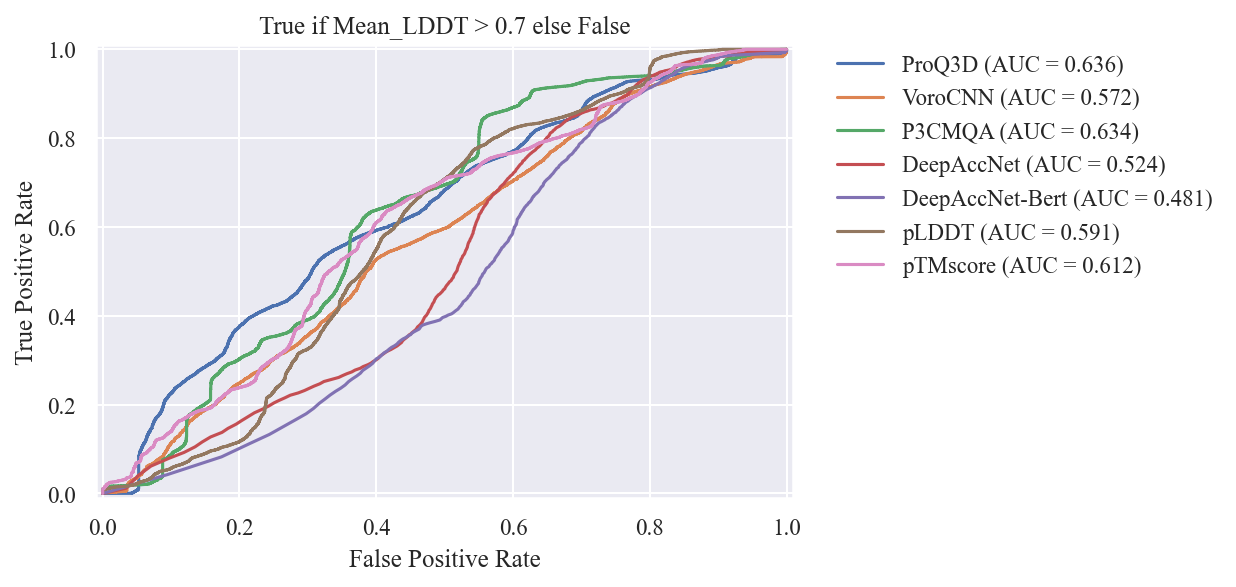

<Figure size 750x600 with 0 Axes>

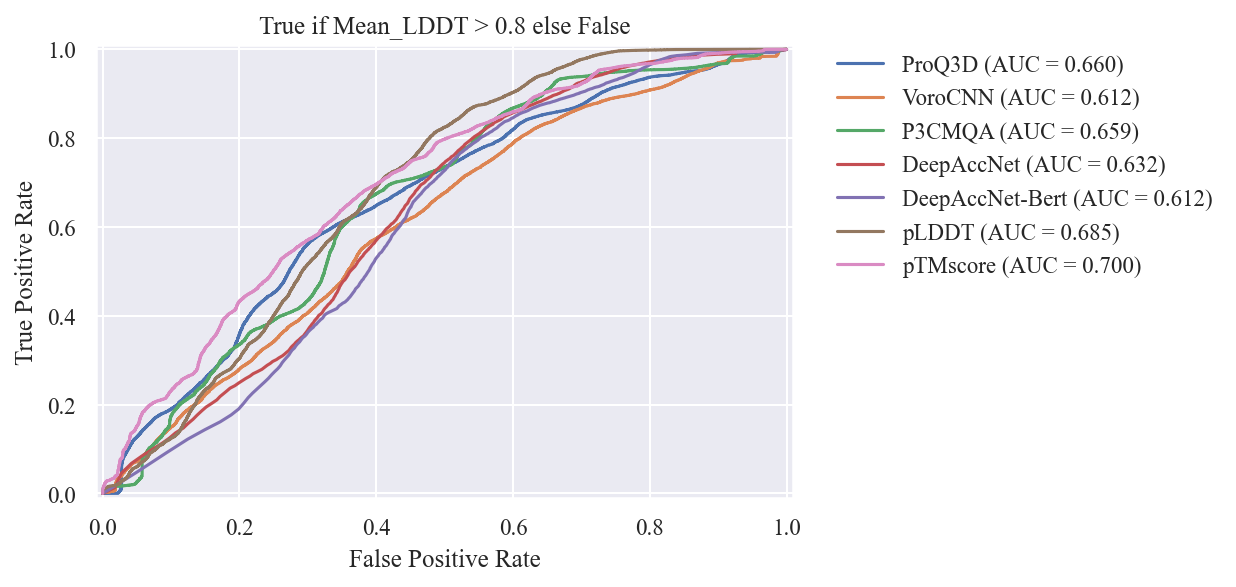

<Figure size 750x600 with 0 Axes>

In [17]:
# For model structures with pTMscore
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'Mean_LDDT']
thresholds = [0.5, 0.6, 0.7, 0.8]
counts = []
data = df[~df['pTMscore'].isna()]
for label in labels:
    for threshold in thresholds:
        l = f'{label}_{threshold}'
        x = data[l]
        for score in methods:
            y = data[score]
            if y.isna().any():
                print(score)
                continue
            fpr, tpr, thres = roc_curve(x, y)
            a= auc(fpr, tpr)
            plt.title(f'True if {label} > {threshold} else False')
            plt.plot(fpr, tpr, label=f'{score} (AUC = {a:.3f})')
            plt.legend()
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, facecolor='white', edgecolor='white')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.figure(figsize=(5, 4))
        plt.tight_layout()
        plt.show()

## Case 2: Negative examples are structures whose label value is lower than the maximum label value by more than threshold

In [18]:
# Against gdtts
mqa_methods = ['DOPE', 'SOAP', 'ProQ3D', 'SBROD', 'VoroCNN', 'P3CMQA', 'DeepAccNet', 'DeepAccNet-Bert']
methods = mqa_methods + ['pLDDT', 'pTMscore']

In [19]:
def split_tf_in_target(group: pd.DataFrame, label: str, threshold: float):
    """False for structures that are a threshold value away from the maximum label value in the target

    Args:
        group (pd.DataFrame): DataFrame of a target.
        label (str, optional): label name. Defaults to 'GDT_TS'.
        threshold (float, optional): Threshold. Defaults to 0.05.
    """
    max_value = group[label].max()
    l = f'{label}-{threshold}'
    group[l] = group[label] + threshold > max_value
    if group[l].all():
        return None
    return group
label = 'GDT_TS'
threshold = 0.05
rel_df = df.groupby('Target').apply(lambda x: split_tf_in_target(x, label, threshold)).reset_index(drop=True)
l = f'{label}-{threshold}'
rel_df[l].value_counts()

True     21957
False    13243
Name: GDT_TS-0.05, dtype: int64

In [20]:
results = []
for method in methods:
    aucs = []
    for name, group in rel_df.groupby('Target'):
        if group[method].isna().any():
                continue
        tpr, fpr, thres = roc_curve(group[l], group[method])
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)
    results.append({'Method': method, 'AUC': np.mean(aucs)})
pd.DataFrame(results)

/Users/TAKEI/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/TAKEI/miniforge3/envs/mypython/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Method   AUC
0             DOPE 0.361
1             SOAP 0.342
2           ProQ3D 0.432
3            SBROD 0.506
4          VoroCNN 0.393
5           P3CMQA 0.402
6       DeepAccNet 0.347
7  DeepAccNet-Bert 0.364
8            pLDDT 0.336
9         pTMscore   NaN

<ipython-input-21-7d7462bf3de5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Label'] = sample_df[label] + threshold > sample_df[label].max()
<ipython-input-21-7d7462bf3de5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Label'] = sample_df['Label'].astype(str)


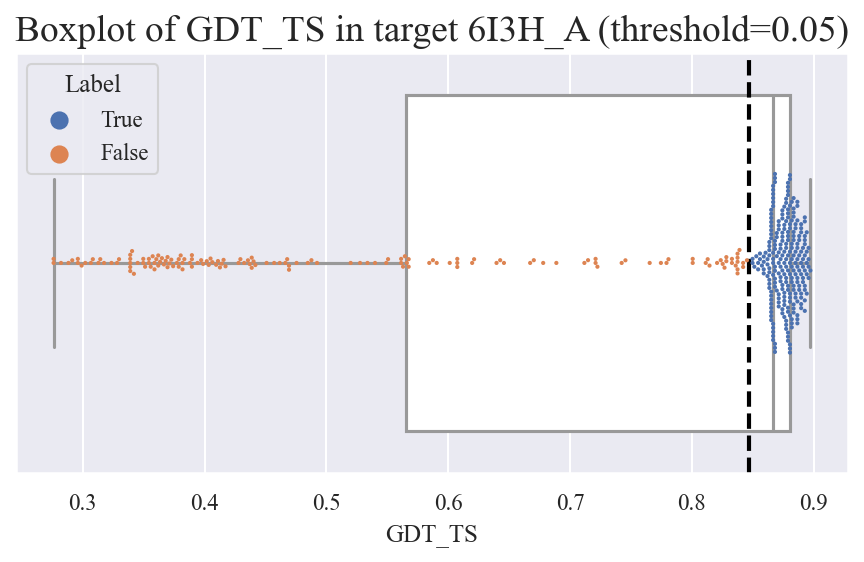

In [21]:
# sample_target = df['Target'].unique()[77]
plt.figure(figsize=(6, 4))
sample_target = '6I3H_A'
threshold = 0.05
sample_df = df[df['Target'] == sample_target]
label = 'GDT_TS'
sample_df['Label'] = sample_df[label] + threshold > sample_df[label].max()
sample_df['Label'] = sample_df['Label'].astype(str)
sns.boxplot(data=sample_df, x=label, color='white')
sns.swarmplot(data=sample_df, x=label, s=2, hue='Label', y=[''] * len(sample_df))
x = sample_df[label].max() - threshold
plt.axvline(x=x, color='black', linestyle='--', linewidth=2)
plt.title(f'Boxplot of GDT_TS in target {sample_target} (threshold={threshold})', fontsize=18)
plt.tight_layout()

GDT_TS 0.05
True     21957
False    13243
Name: GDT_TS-0.05, dtype: int64
99


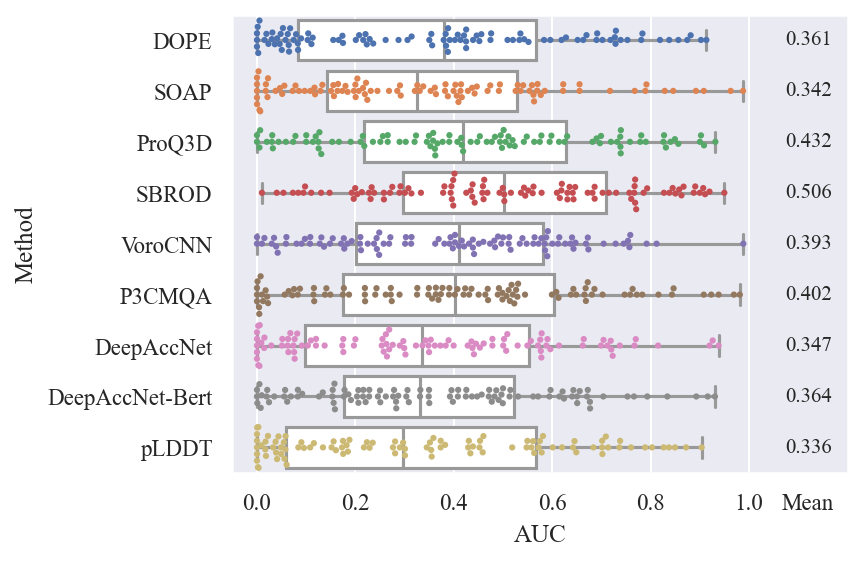

AUC
Method               
DOPE            0.361
DeepAccNet      0.347
DeepAccNet-Bert 0.364
P3CMQA          0.402
ProQ3D          0.432
SBROD           0.506
SOAP            0.342
VoroCNN         0.393
pLDDT           0.336

GDT_TS 0.1
True     8723
False    4877
Name: GDT_TS-0.1, dtype: int64
39


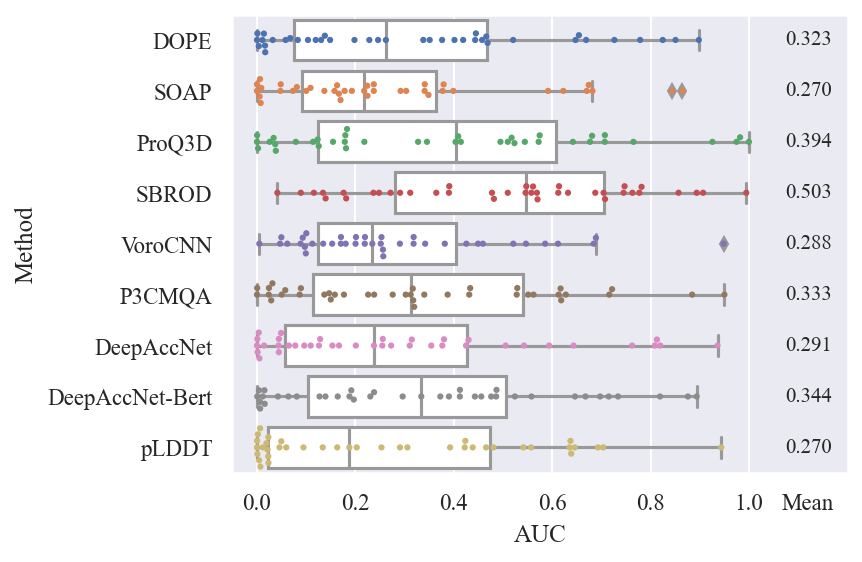

AUC
Method               
DOPE            0.323
DeepAccNet      0.291
DeepAccNet-Bert 0.344
P3CMQA          0.333
ProQ3D          0.394
SBROD           0.503
SOAP            0.270
VoroCNN         0.288
pLDDT           0.270

GDT_TS 0.15
True     6951
False    2449
Name: GDT_TS-0.15, dtype: int64
28


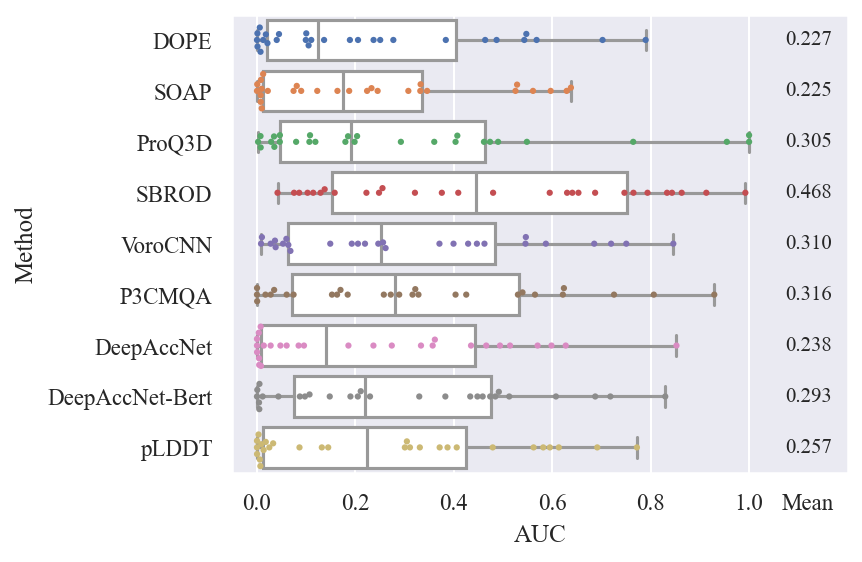

AUC
Method               
DOPE            0.227
DeepAccNet      0.238
DeepAccNet-Bert 0.293
P3CMQA          0.316
ProQ3D          0.305
SBROD           0.468
SOAP            0.225
VoroCNN         0.310
pLDDT           0.257

GDT_TS 0.2
True     4606
False    1594
Name: GDT_TS-0.2, dtype: int64
18


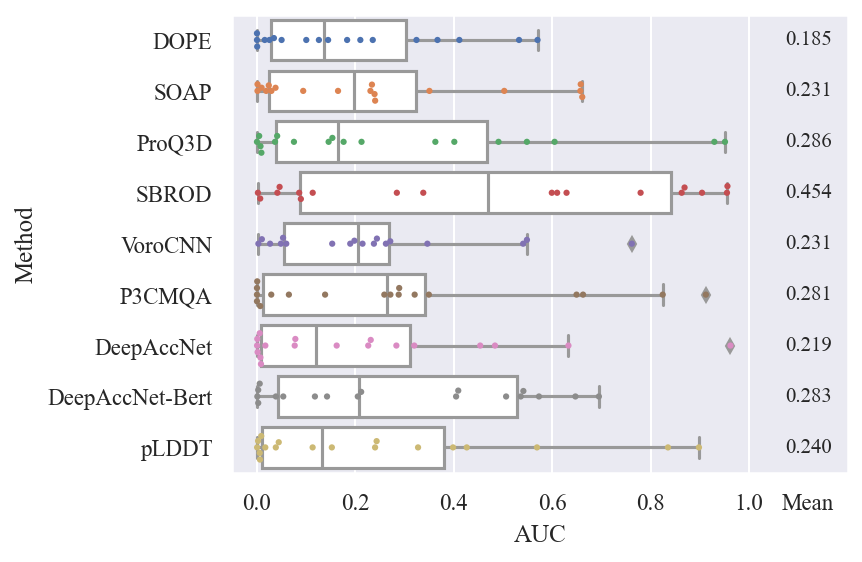

AUC
Method               
DOPE            0.185
DeepAccNet      0.219
DeepAccNet-Bert 0.283
P3CMQA          0.281
ProQ3D          0.286
SBROD           0.454
SOAP            0.231
VoroCNN         0.231
pLDDT           0.240

GDT_HA 0.05
True     47610
False    19990
Name: GDT_HA-0.05, dtype: int64
190


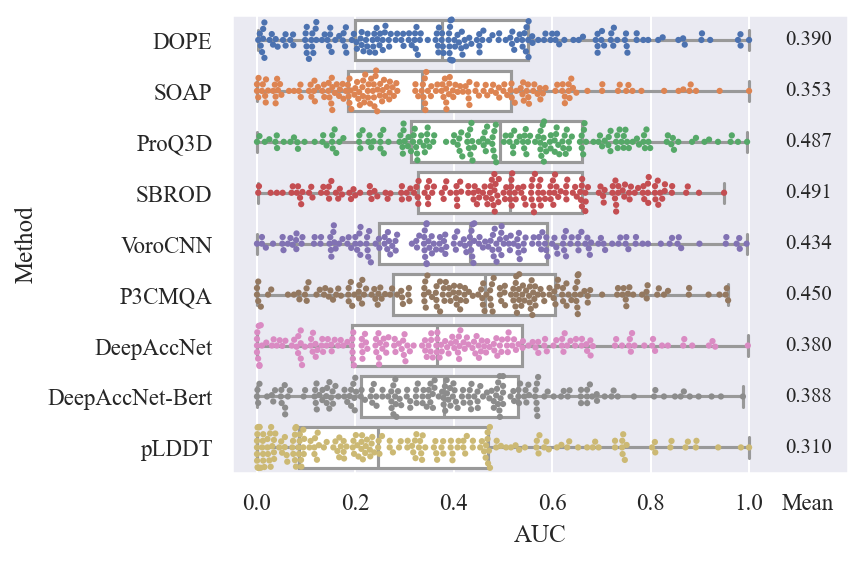

AUC
Method               
DOPE            0.390
DeepAccNet      0.380
DeepAccNet-Bert 0.388
P3CMQA          0.450
ProQ3D          0.487
SBROD           0.491
SOAP            0.353
VoroCNN         0.434
pLDDT           0.310

GDT_HA 0.1
True     17672
False     5928
Name: GDT_HA-0.1, dtype: int64
67


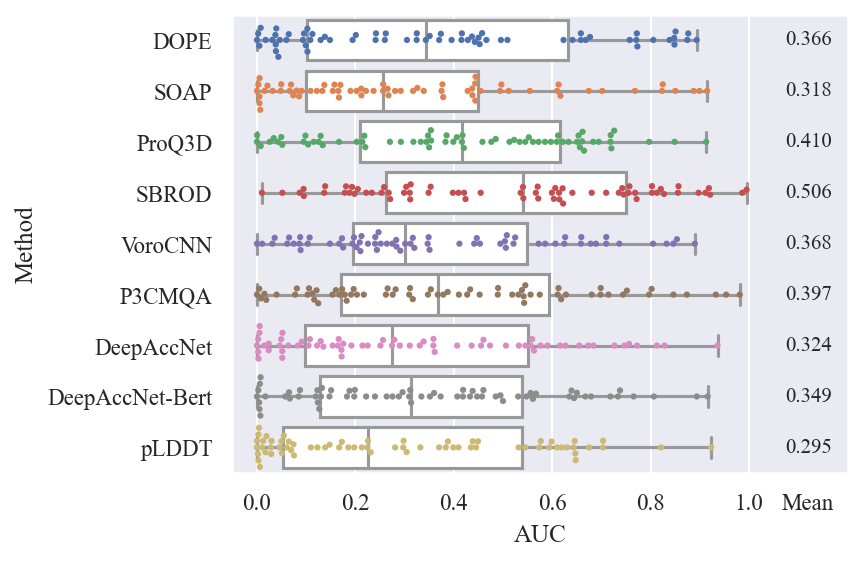

AUC
Method               
DOPE            0.366
DeepAccNet      0.324
DeepAccNet-Bert 0.349
P3CMQA          0.397
ProQ3D          0.410
SBROD           0.506
SOAP            0.318
VoroCNN         0.368
pLDDT           0.295

GDT_HA 0.15
True     8668
False    2732
Name: GDT_HA-0.15, dtype: int64
33


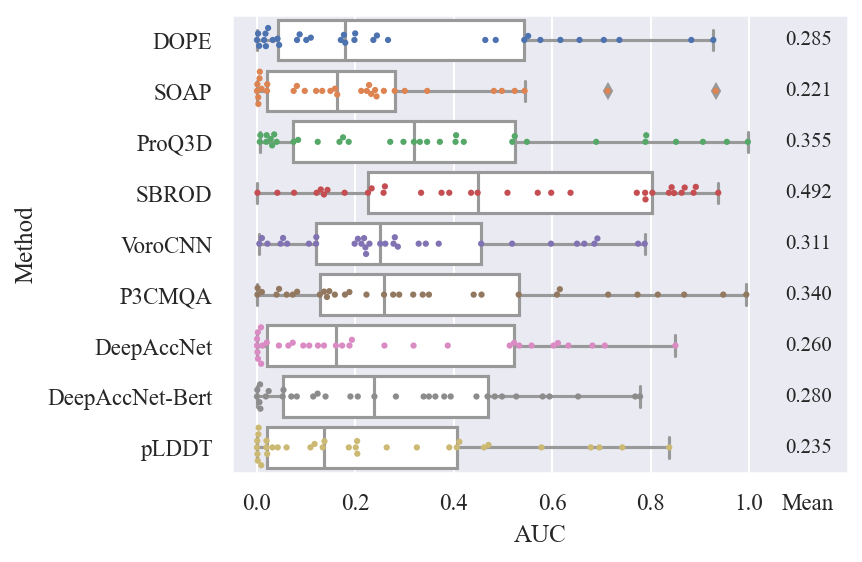

AUC
Method               
DOPE            0.285
DeepAccNet      0.260
DeepAccNet-Bert 0.280
P3CMQA          0.340
ProQ3D          0.355
SBROD           0.492
SOAP            0.221
VoroCNN         0.311
pLDDT           0.235

GDT_HA 0.2
True     5178
False    1822
Name: GDT_HA-0.2, dtype: int64
20


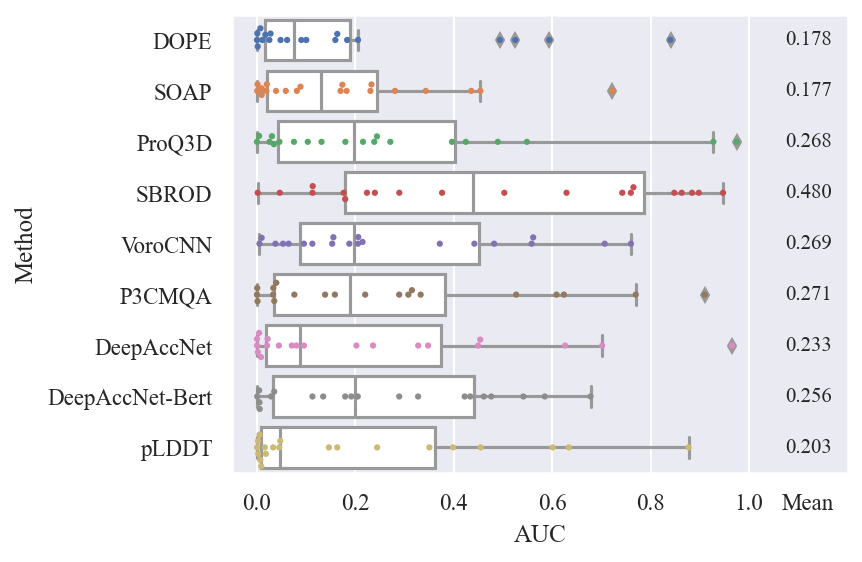

AUC
Method               
DOPE            0.178
DeepAccNet      0.233
DeepAccNet-Bert 0.256
P3CMQA          0.271
ProQ3D          0.268
SBROD           0.480
SOAP            0.177
VoroCNN         0.269
pLDDT           0.203

TMscore 0.05
True     12060
False     9540
Name: TMscore-0.05, dtype: int64
59


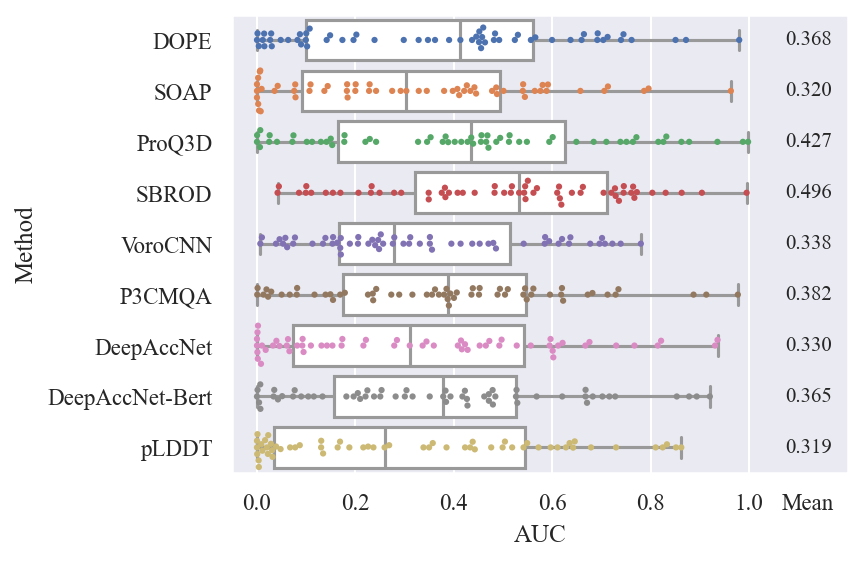

AUC
Method               
DOPE            0.368
DeepAccNet      0.330
DeepAccNet-Bert 0.365
P3CMQA          0.382
ProQ3D          0.427
SBROD           0.496
SOAP            0.320
VoroCNN         0.338
pLDDT           0.319

TMscore 0.1
True     7156
False    4244
Name: TMscore-0.1, dtype: int64
33


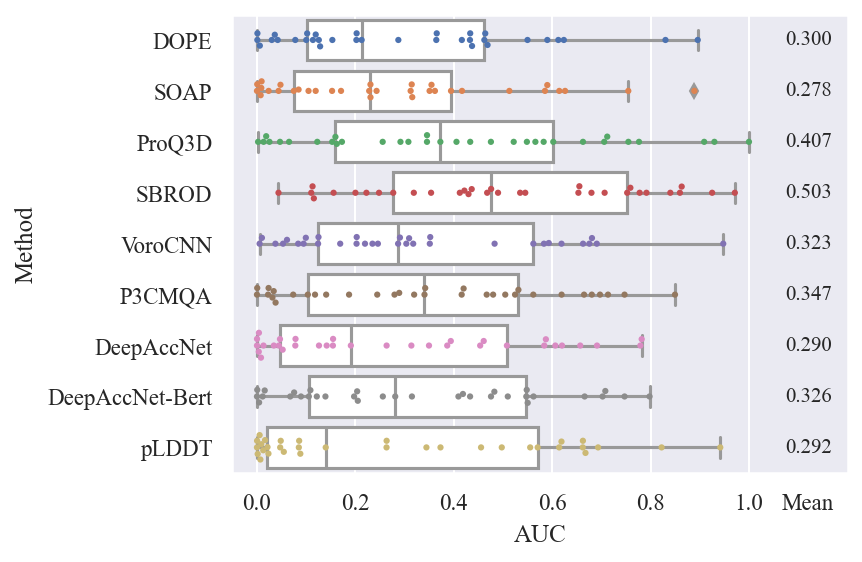

AUC
Method               
DOPE            0.300
DeepAccNet      0.290
DeepAccNet-Bert 0.326
P3CMQA          0.347
ProQ3D          0.407
SBROD           0.503
SOAP            0.278
VoroCNN         0.323
pLDDT           0.292

TMscore 0.15
True     6038
False    2362
Name: TMscore-0.15, dtype: int64
24


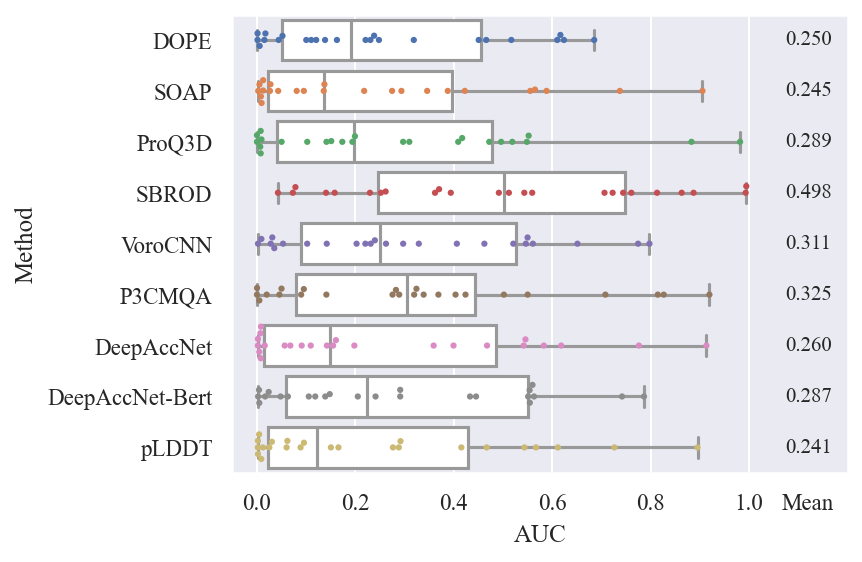

AUC
Method               
DOPE            0.250
DeepAccNet      0.260
DeepAccNet-Bert 0.287
P3CMQA          0.325
ProQ3D          0.289
SBROD           0.498
SOAP            0.245
VoroCNN         0.311
pLDDT           0.241

TMscore 0.2
True     4253
False    1547
Name: TMscore-0.2, dtype: int64
17


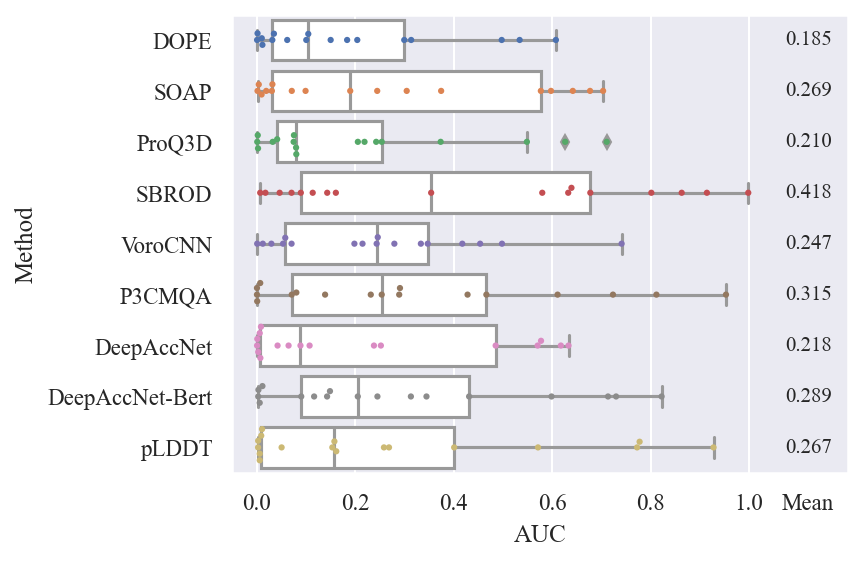

AUC
Method               
DOPE            0.185
DeepAccNet      0.218
DeepAccNet-Bert 0.289
P3CMQA          0.315
ProQ3D          0.210
SBROD           0.418
SOAP            0.269
VoroCNN         0.247
pLDDT           0.267

In [22]:
labels = ['GDT_TS', 'GDT_HA', 'TMscore']
thresholds = [0.05, 0.1, 0.15, 0.2]
for label in labels:
    for threshold in thresholds:
        rel_df = df.groupby('Target').apply(lambda x: split_tf_in_target(x, label, threshold)).reset_index(drop=True)
        l = f'{label}-{threshold}'
        print(label, threshold)
        print(rel_df[l].value_counts())
        print(rel_df['Target'].unique().size)
        results = []
        for method in methods:
            aucs = []
            targets = []
            for name, group in rel_df.groupby('Target'):
                if group[method].isna().any():
                    continue
                tpr, fpr, thres = roc_curve(group[l], group[method])
                auc_score = auc(fpr, tpr)
                aucs.append(auc_score)
                targets.append(name)
            if len(aucs) == 0:
                continue
            results.append(pd.DataFrame({'Method': method, 'AUC': aucs, 'Target': targets}))
        cdf = pd.concat(results)
        sns.boxplot(data=cdf, y='Method', x='AUC', color='white')
        sns.swarmplot(data=cdf, y='Method', x='AUC', s=3)
        xticks_max = 1.12
        plt.xlim(-0.05, 1.2)
        xticks = np.append(np.arange(0, 1.2, 0.2), [xticks_max])
        xticks_str = list(map(lambda x: f'{x:.1f}', xticks))
        xticks_str[-1] = 'Mean'
        plt.xticks(xticks, xticks_str)
        plt.axvline(x=xticks_max, color=(234/255,234/255,242/255))
        mean_series = cdf.groupby('Method').mean()['AUC']
        for i, method in enumerate(methods):
            if method not in mean_series.index:
                continue
            value = mean_series[method]
            plt.text(xticks_max, i, f'{value:.3f}', size=10, horizontalalignment='center', verticalalignment='center')
        plt.tight_layout()
        plt.show()
        display(cdf.groupby('Method').mean())